In [1]:
import matplotlib.pyplot as plt
from preprocess_functions import preprocess #preprocess is a class containing all the function, not sure why I made it a class
#May have to specify the location of the preprocess_functions files relative to this one
import numpy as np
import os

## Finding the right files
First it can be useful to locate and save the path to several fluorescence files at once, but One can also just do it one by one. 
For now, the code in preprocess_functions.py is built around the flourescence.csv file. However, this will soon be changed, as I have discovered that it is aligned to the isosbestic frame, which I'm not using, and the timestamps for the events are therefore not perfectly aligned. 

But for now, here's a way to use os.walk to get several files at once.

In [2]:

rootdir = '/Users/hildeteigen/Documents/Photometry_data/test_data' #path to the forlder in which you hav all the recordings

paths=[]
for dirpath, subdirs, files in os.walk(rootdir): #This walks through the folders and files
    for x in files:
       if x == 'Fluorescence.csv': #if the file in a folder has this name, we save its path to a list of paths
            paths.append(os.path.join(dirpath))

In [3]:
#paths = ['/Volumes/RanczLab/Photometry_recordings/August_Mismatch_Experiment_GRAB/B3M8_MMclosed_and_Regular_day1/2024_08_22-13_34_31/']


## Applying the relevant preprocessing functions
Have a look at the printed text. Ensure that the mouse ID is correct. If you have a different way of naming the files and, the code will need to be adjusted. 

For now, it uses the folder name to get the mouse ID and the experiment name.

It asks for the sex of the animal and the location of the fiber. I usually write M or F for the sex, and V2M or V1 for the location. Whatever you do name it, it's best to be consistent to make the data analysis better. 

First, lets do it one by one.

In [4]:
path = paths[0] #selecting a random path
print(path)

/Users/hildeteigen/Documents/Photometry_data/test_data/B3M3_vers1_spatiotemporal/2024_07_18-17_06_55


In [5]:
# selecting a sensor. For now, the functions respond to 'G8m', 'g5-HT3', or half decay time in ms.
sensors = ['G8m']

# Now create an object which will contain an increasing amount of information as functions are called on
# Now it is just an object with a self containing the sensor name and the path and some colors for plotting
processed_1 = preprocess(path, sensors)

In [6]:
# extract all relevant and irrelevant info from the csv file
processed_1.Info = processed_1.get_info()
print(processed_1.Info)

{'Light': {'Led410Enable': True, 'Led470Enable': True, 'Led560Enable': True, 'Led410Value': 2.0, 'Led470Value': 6.0, 'Led560Value': 4.8}, 'Excitation': {'mode': 3, 'discontinuous': False, 'interval_time': 20, 'continuous_time': 20}, 'Channels': [{'Name': 'CH1', 'Roi1': '263.630985915492,206.492957746479,166.901408450704,166.901408450704', 'Roi2': '264.143661971832,203.929577464789,166.901408450704,166.901408450704'}], 'AllMarking': [{'id': 0, 'type': 1, 'opened': True, 'name': 'y', 'Levels': 0, 'color': '#FF9BBB59', 'key': 0, 'threshold': 0.0, 'all': True, 'channels': ['AllChannel', 'CH1'], 'enable': True}, {'id': 0, 'type': 2, 'opened': True, 'name': 'Input1', 'Levels': 0, 'color': '#FF0099FF', 'key': 0, 'threshold': 0.0, 'all': True, 'channels': ['AllChannel', 'CH1'], 'enable': True}], 'Fps': 90.0}


In [7]:
processed_1.rawdata, processed_1.data, processed_1.data_seconds, processed_1.signals, processed_1.save_path = processed_1.create_basic()
'''
Here, we run the create_basic() function. This involves saving some data for later. 
- The first element is the raw-data, just meaning that it is just saved to the object
- The second element gives the cut data, now cutting the first 15 seconds due to initial bleaching
- The third element is just the timestamps made into seconds (rather than milliseconds)
- The fourth elements is a df of flourescent traces only from each of the recorded exitatory wavelenghts
- Fith element is the path created in which the preprocessed file and plots will be saved. 
    This part assumes the presence of a folder in the same location as this file named 'preprocessed' where all preprocessed data can be saved
    If it does not exist already, there is created folders 
    named by the encloding experiment folder, the animal folder, and the time and date folder.
    If it already exists - whatch out, whatever is stored there will be overwritten if it has the same names 
        - for example if you already preprocessed it
    For now, this is an empty folder
'''
print('\nFolder created or already exsisting:\n', processed_1.save_path)

         TimeStamp     470     410    560   Event  State
450      15011.117  42.917  10.815  8.333     NaN    NaN
451      15044.447  42.808  10.848  8.356     NaN    NaN
452      15077.780  42.739  10.849  8.330     NaN    NaN
453      15111.112  42.797  10.856  8.342     NaN    NaN
454      15144.450  42.699  10.854  8.331     NaN    NaN
...            ...     ...     ...    ...     ...    ...
35277  1175756.144  40.410   9.736  8.011  Input1    1.0
35278  1175789.471  40.348   9.746  7.997  Input1    1.0
35279  1175822.802  40.343   9.739  7.987  Input1    1.0
35280  1175856.133  40.579   9.779  8.001  Input1    1.0
35281  1175889.461  40.029   9.744  8.030  Input1    1.0

[34832 rows x 6 columns]
Directory Processed/test_data/vers1_spatiotemporal/already exists
Processed/test_data/vers1_spatiotemporal/B3M3_2024_07_18-17_06_55 already exists

Folder created or already exsisting:
 Processed/test_data/vers1_spatiotemporal/B3M3_2024_07_18-17_06_55


In [8]:
processed_1.events = processed_1.extract_events()
'''
now we have an element 'events' containing timestamped events
for each event there will be a _starts and a _stops and a _event
 _starts: numpy nans for all rows except at the time stamp where the event starts
 _stops: numpy nans for all rows except at the time stamp where the event stops
 _events: False whenever the event did not take place, and True while it did take place
 The event is named the same as was as it was recorded
'''
processed_1.events

Input1_event
450           False
451           False
452           False
453           False
454           False
...             ...
35277         False
35278         False
35279         False
35280         False
35281         False

[34832 rows x 1 columns]

### Filtering
Now, by running and saving the low_pass_filt() function, all the sigals are low pass filtered using a butterworth filter. This  is where the sensor comes in, as it decides the critical frequency used, which needs to be adapted to the decay time of the sensor.
The plot that is made is of the raw trace and the filtered trace, and is also saved to the folder created above, where is can be looked at in more detail. 

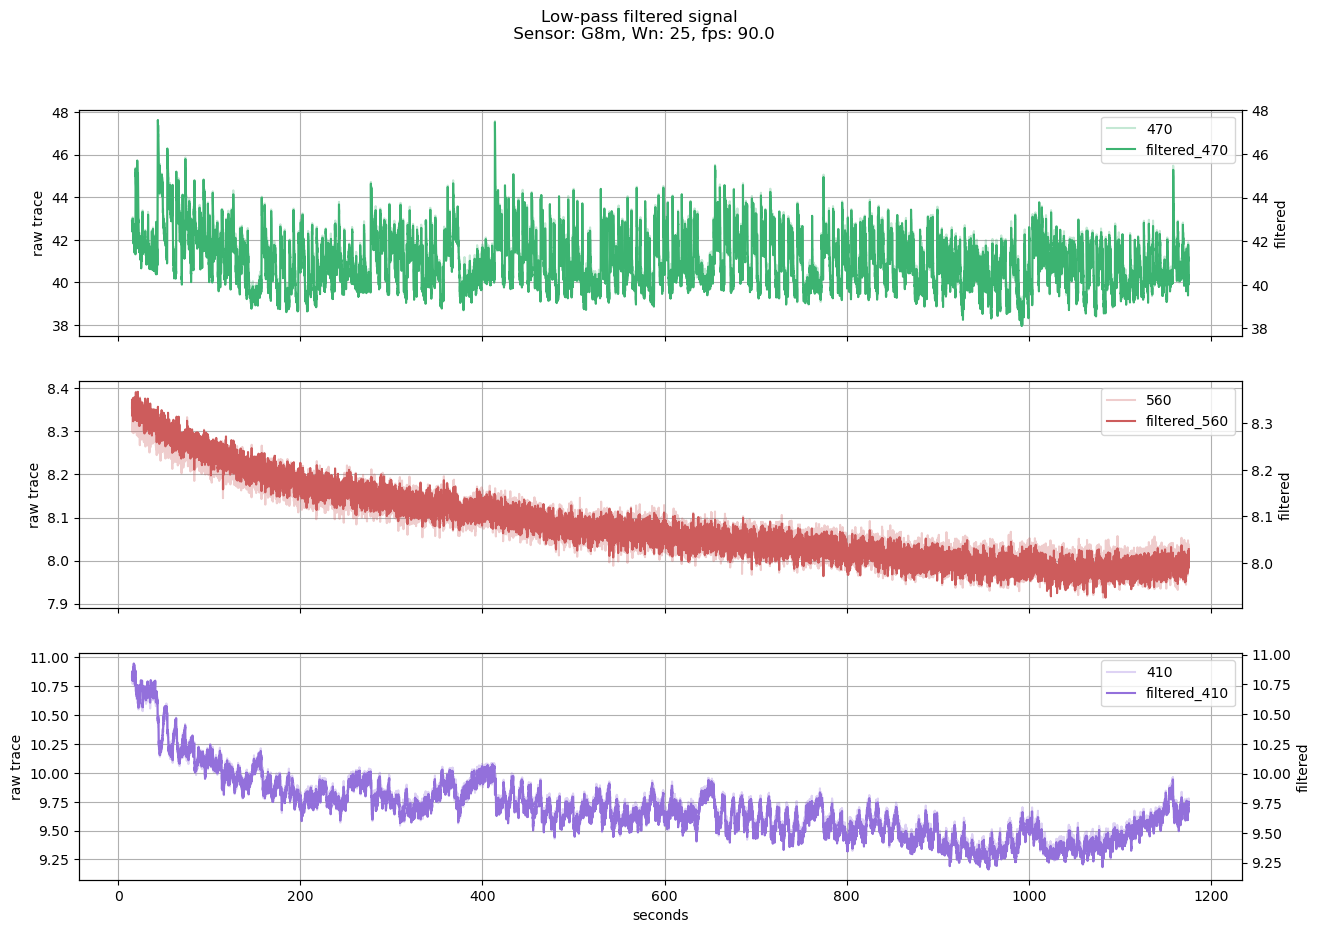

In [9]:
processed_1.filtered = processed_1.low_pass_filt()

### Detrending
A double exponential fit is made to account for sources of bleaching, and this is then subtracted from the flourescence treaces to get a detreded signal.
It plots two things: the detrended signals and the original signals along with the exponential fit, to see if it makes sense.
Also prints the parameters used for filtering.

Parameters used for detrending filtered_470:  [3.55304608e+01 2.69360204e+00 5.49918174e+00 2.13905948e+04
 2.99365120e-03]
Parameters used for detrending filtered_560:  [7.86815009e+00 1.40916953e-01 3.49692735e-01 1.00000000e+03
 1.03491192e-01]
Parameters used for detrending filtered_410:  [9.10604707e+00 1.26884621e+00 9.22003018e-01 1.12042061e+03
 3.88767013e-02]


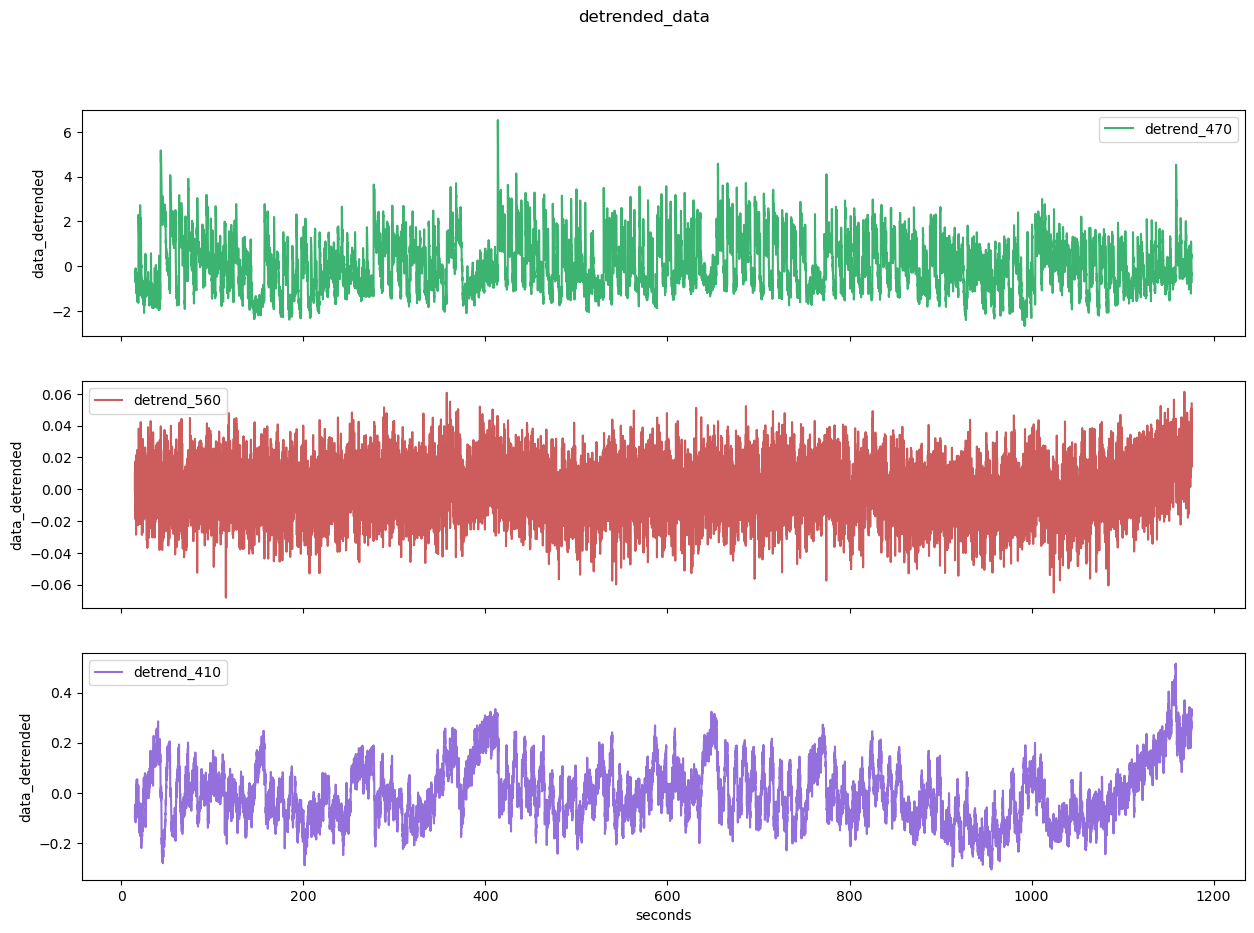

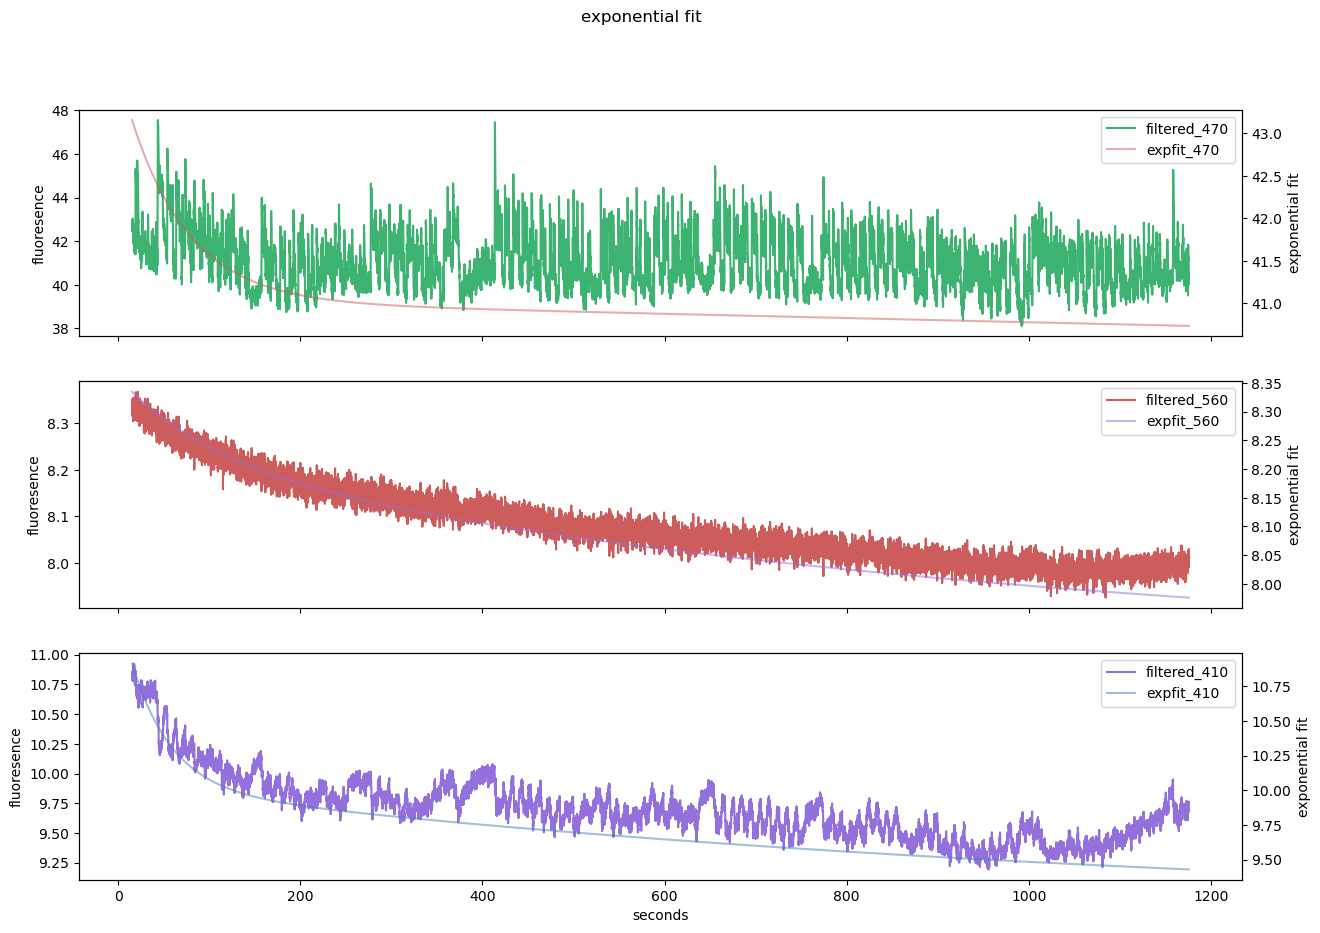

In [10]:
processed_1.data_detrended, processed_1.exp_fits = processed_1.detrend()

### Motion correction
There is a motion correction function that can be used. It is now set to use the 560 nm signa, because of my doubts with the relevans of the 410 nm signal as isosbestic trace. For now, I recommend not running this one.

The slope of the linear regression between the main signal and the control is:  -2.071482500210751
signal could not be motion corrected
-2.1759642085819435e-07 -2.071482500210751


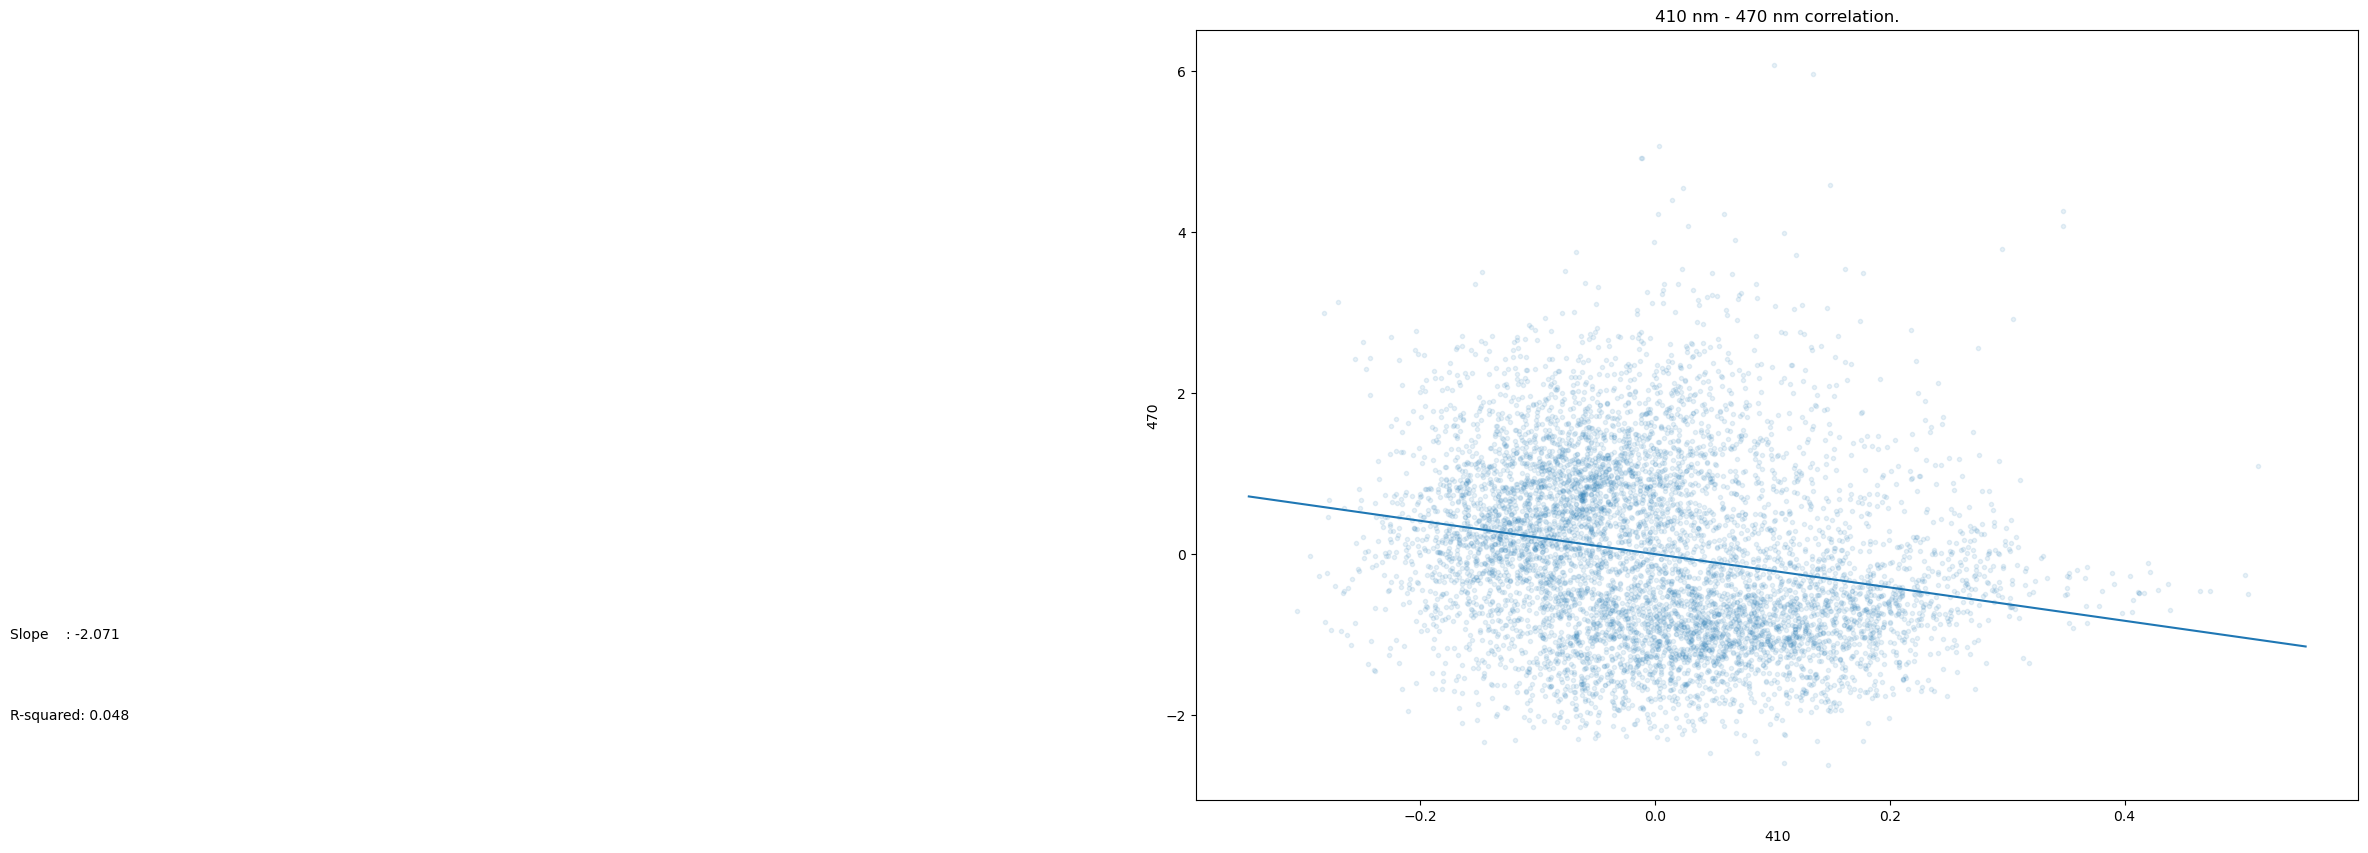

In [11]:
processed_1.motion_corr = processed_1.movement_correct()

### Z-scoring
Takes the median and standard deviation of the trace. Then subtracts the median from all datapoints and divides by the standard deviation. If motion correction has been run, then it does so with the motion corrected traces, if motion is set to False. Actually, it is defaulth set to False, so its not necessary, but it can also be set to True, to have a look at how it would be with the motion correction.

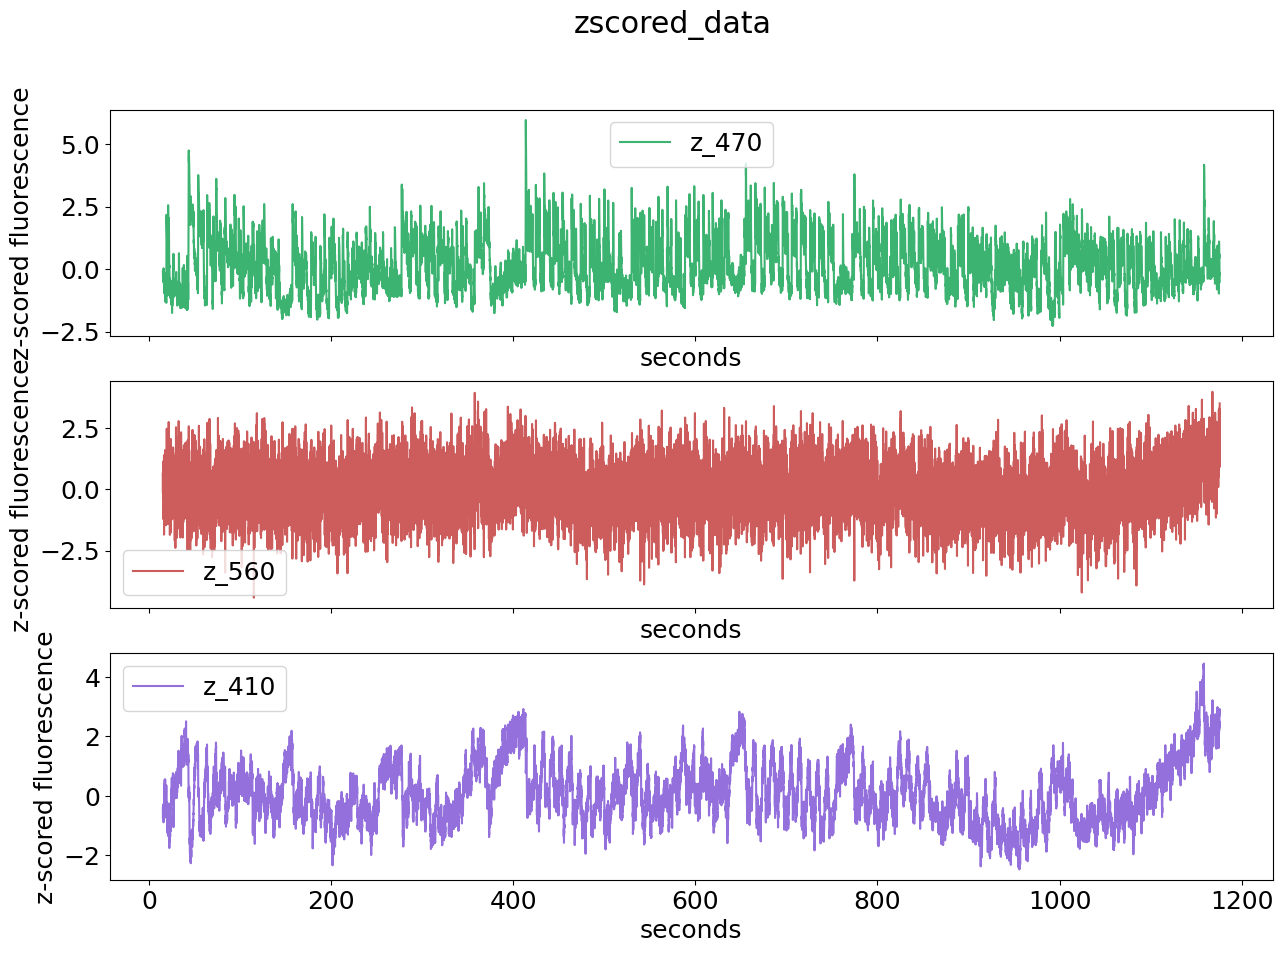

In [12]:
processed_1.zscored = processed_1.z_score(motion = False)

### Delta F / F
This is a standard way of calculating the detla F over F signal, i.e. the % change in signal. I do think it is a bit weird to use the detrending exponential fit again. I have wondered if I should change it to just a linear fit to the current detrended signal. For now I do this based on the fiber photometry primer paper code: https://github.com/ThomasAkam/photometry_preprocessing/blob/master/Photometry%20data%20preprocessing.ipynb

Again, 'motion' can be set to True, bu tis defaulth False


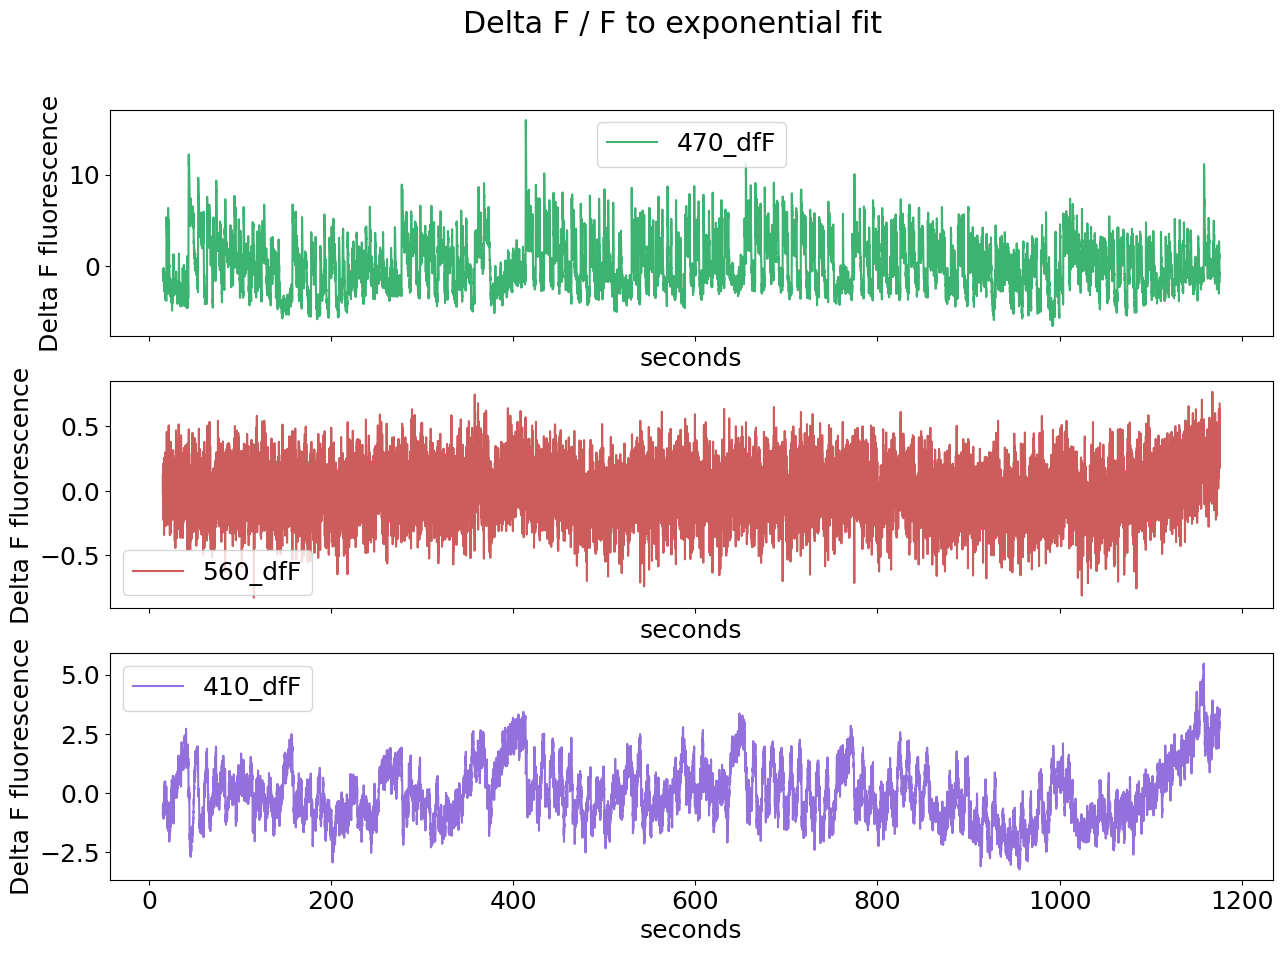

In [13]:
processed_1.deltaF_F = processed_1.deltaF_F(motion = False)

### Add crucial info
Here, some crucial info is added that will be included in the output csv file in the end. 
This includes the mouse ID, which is currently automatically taken from the folder name. However, if the folder is not named in this way, the function will need adjustment to account for some other way of getting the mouse ID.
The function will ask you to provide the following:
-  Location of fluorescent protein: write something simple and consistent across different recordings, like V1 and V2M
-  Sex of the animal (cause that could be relevant): easiest to just write F or M

In [15]:
processed_1.crucial_info = processed_1.add_crucial_info()

Please ensure that B3M3 is the correct mouse ID 
 If not, changes must be made to either add_crucial_info fucntion or file naming
Mouse B3M3


Add the location of fluorescent protein:  V1
Add the sex of the mouse:  M


### Save it as a .csv files
This function will lead to it all being saved as a csv file which can easily be read as a pandas dataframe when the data is to be analysed.
First it is the info csv, which I for now save, but never actually use...
Then it is the main csv file which is very useful indeed. For this one you can add Events = True to also save the events, and motion_correct = True if you have doen motion correction and want to use this.The only difference for the latter, is really that it also saved the motion corrected raw signal. Regardless, if you did use motion correction for deltaF and z-score, this is the version that will be saved

In [16]:
#again it ensures that the folder to save in already exists, since the csv must have somewhere to be
processed_1.info_csv = processed_1.write_info_csv()
processed_1.data_csv = processed_1.write_preprocessed_csv(Events = True, motion_correct = False)
#optional: Events = True, motion_correct = True

Events added
preprocessed.csv file saved to  Processed/test_data/vers1_spatiotemporal/B3M3_2024_07_18-17_06_55


### Have a look
By importing pandas, you can now read the file, by compying the path from above and adding 'preprocessed.csv' which is the name of your new file. Sorry about the unnamed file. It can be removed. I'll do that

In [17]:
import pandas as pd
pd.read_csv('Processed/test_data/vers1_spatiotemporal/B3M3_2024_07_18-17_06_55'+'/preprocessed.csv')

TimeStamp   470_dfF   560_dfF   410_dfF     z_470     z_560  \
0        15.011117 -0.554998 -0.018268 -0.913839 -0.096219 -0.094031   
1        15.044447 -0.814968  0.125609 -0.660871 -0.196706  0.685782   
2        15.077780 -0.887156  0.091862 -0.530568 -0.224601  0.502869   
3        15.111112 -0.912838  0.018641 -0.531006 -0.234520  0.106015   
4        15.144450 -1.085131 -0.043569 -0.629999 -0.301106 -0.231157   
...            ...       ...       ...       ...       ...       ...   
34827  1175.756144 -0.849991  0.328352  3.282993 -0.191820  1.708111   
34828  1175.789471 -0.983292  0.274903  3.303158 -0.240459  1.430877   
34829  1175.822802 -0.703020  0.174505  3.445214 -0.138194  0.910123   
34830  1175.856133 -0.743066  0.305257  3.544907 -0.152806  1.588321   
34831  1175.889461 -1.734443  0.676479  3.342515 -0.514537  3.513805   

          z_410                        Time mouseID Area Sex  Input1_event  
0     -0.737702  2024-07-18 17:07:10.011117    B3M3   V1   M         False  
1     -0.504622  2024-07-18 17:07:10.044447    B3M3   V1   M         False  
2     -0.384560  2024-07-18 17:07:10.077780    B3M3   V1   M         False  
3     -0.384931  2024-07-18 17:07:10.111112    B3M3   V1   M         False  
4     -0.476070  2024-07-18 17:07:10.144450    B3M3   V1   M         False  
...         ...                         ...     ...  ...  ..           ...  
34827  2.716796  2024-07-18 17:26:30.756144    B3M3   V1   M         False  
34828  2.732841  2024-07-18 17:26:30.789471    B3M3   V1   M         False  
34829  2.845888  2024-07-18 17:26:30.822802    B3M3   V1   M         False  
34830  2.925223  2024-07-18 17:26:30.856133    B3M3   V1   M         False  
34831  2.764154  2024-07-18 17:26:30.889461    B3M3   V1   M         False  

[34832 rows x 12 columns]

### Mass production
When several paths are saved in one list, we can just loop through the list and create all the files. It is  a good idea to have a look at all the saved plots anyways. Also, for now you must wait for the prompts to add the crucial info. If you prefer I can change it so that you can add that some other way, but I like this way so I can be certain that I get it right. 

In [4]:
import os
paths = []
root = '/Volumes/RanczLab/GRAB_agonist_test'
for root, dirs, files in os.walk(root):
    for filename in files:
        if filename == 'Fluorescence-unaligned.csv':
            if 'wakeup' in root:
                paths.append(root)
[print(path) for path in paths]

/Volumes/RanczLab/GRAB_agonist_test/B3M5_30mgkg_wakeup/2024_07_10-18_27_44
/Volumes/RanczLab/GRAB_agonist_test/B3M5_noinject_wakeup/2024_07_08-16_04_05
/Volumes/RanczLab/GRAB_agonist_test/B3M6_30mgkg_wakeup/2024_07_10-13_26_18
/Volumes/RanczLab/GRAB_agonist_test/B3M8_30mgkg_wakeup/2024_07_09-17_37_29
/Volumes/RanczLab/GRAB_agonist_test/B2M6_30mgkg_wakeup/2024_07_03-14_00_56
/Volumes/RanczLab/GRAB_agonist_test/B2M6_wakeup/2024_06_07-18_07_38
/Volumes/RanczLab/GRAB_agonist_test/B3M7_30mgkg_wakeup/2024_07_04-15_17_10
/Volumes/RanczLab/GRAB_agonist_test/B3M4_30mgkg_wakeup/2024_07_09-13_36_56


[None, None, None, None, None, None, None, None]



  Preprocessing data for B3M5 at 2024_07_10-18_27_44 ... 

Directory Processed/GRAB_agonist_test/30mgkg_wakeup/already exists
Processed/GRAB_agonist_test/30mgkg_wakeup/B3M5_2024_07_10-18_27_44 already exists
No filtered signal was found
Parameters used for detrending 470:  [7.20920942e+01 2.41522440e-10 8.93538260e-08 3.59595420e+04
 9.99997919e-01]
Parameters used for detrending 560:  [4.20461938e+01 1.73767573e+00 4.87501260e-29 2.11509471e+04
 3.60516325e-02]
Parameters used for detrending 410:  [6.90364765e+00 5.10278802e+00 1.42802880e+01 3.59999999e+04
 9.99999999e-01]
Please ensure that B3M5 is the correct mouse ID 
 If not, changes must be made to either add_crucial_info fucntion or file naming
Mouse B3M5


Add the location of fluorescent protein:  V2M
Add the sex of the mouse:  M


Events added
preprocessed.csv file saved to  Processed/GRAB_agonist_test/30mgkg_wakeup/B3M5_2024_07_10-18_27_44


  Preprocessing data for B3M5 at 2024_07_08-16_04_05 ... 

Directory Processed/GRAB_agonist_test/noinject_wakeup/already exists
Processed/GRAB_agonist_test/noinject_wakeup/B3M5_2024_07_08-16_04_05 already exists
No filtered signal was found
Parameters used for detrending 470:  [6.84311726e+01 8.99079204e-11 2.02873188e-07 3.54223059e+04
 9.99970195e-01]
Could not fit exponential fit for: 
 /Volumes/RanczLab/GRAB_agonist_test/B3M5_noinject_wakeup/2024_07_08-16_04_05/
Parameters used for detrending 560:  [6.84311726e+01 8.99079204e-11 2.02873188e-07 3.54223059e+04
 9.99970195e-01]
Parameters used for detrending 410:  [2.59586031e+01 4.10493831e-14 2.62338767e-10 3.60000000e+04
 7.23448799e-05]
Please ensure that B3M5 is the correct mouse ID 
 If not, changes must be made to either add_crucial_info fucntion or file naming
Mouse B3M5


Add the location of fluorescent protein:  V2M
Add the sex of the mouse:  M


Events added
preprocessed.csv file saved to  Processed/GRAB_agonist_test/noinject_wakeup/B3M5_2024_07_08-16_04_05


  Preprocessing data for B3M6 at 2024_07_10-13_26_18 ... 

Directory Processed/GRAB_agonist_test/30mgkg_wakeup/already exists
Processed/GRAB_agonist_test/30mgkg_wakeup/B3M6_2024_07_10-13_26_18 already exists
No filtered signal was found
Parameters used for detrending 470:  [1.31293980e+02 2.69109684e-08 7.33234338e-11 3.59939932e+04
 9.99998591e-01]
Parameters used for detrending 560:  [2.70751358e+01 4.01264877e-01 7.41303980e+00 3.18499767e+04
 2.63472268e-03]
Parameters used for detrending 410:  [5.99273502e+01 5.63502530e-12 1.36849624e-09 3.57832966e+04
 9.99996785e-01]
Please ensure that B3M6 is the correct mouse ID 
 If not, changes must be made to either add_crucial_info fucntion or file naming
Mouse B3M6


Add the location of fluorescent protein:  V2M
Add the sex of the mouse:  F


Events added
preprocessed.csv file saved to  Processed/GRAB_agonist_test/30mgkg_wakeup/B3M6_2024_07_10-13_26_18


  Preprocessing data for B3M8 at 2024_07_09-17_37_29 ... 

Directory Processed/GRAB_agonist_test/30mgkg_wakeup/already exists
Processed/GRAB_agonist_test/30mgkg_wakeup/B3M8_2024_07_09-17_37_29 already exists
No filtered signal was found
Parameters used for detrending 470:  [7.05479901e+01 6.08412652e-10 2.87595622e-11 1.73808041e+04
 9.99989546e-01]
Parameters used for detrending 560:  [3.69933335e+01 1.85806102e+00 6.38698131e-06 2.65707609e+04
 5.19853980e-03]
Parameters used for detrending 410:  [2.98000282e+01 1.68821747e-10 1.99346987e-09 3.59999980e+04
 9.99999959e-01]
Please ensure that B3M8 is the correct mouse ID 
 If not, changes must be made to either add_crucial_info fucntion or file naming
Mouse B3M8


Add the location of fluorescent protein:  V2M
Add the sex of the mouse:  F


Events added
preprocessed.csv file saved to  Processed/GRAB_agonist_test/30mgkg_wakeup/B3M8_2024_07_09-17_37_29


  Preprocessing data for B2M6 at 2024_07_03-14_00_56 ... 

Directory Processed/GRAB_agonist_test/30mgkg_wakeup/already exists
Processed/GRAB_agonist_test/30mgkg_wakeup/B2M6_2024_07_03-14_00_56 already exists
No filtered signal was found
Parameters used for detrending 470:  [1.00548906e+02 4.36910155e-11 1.62096228e-11 1.64403531e+04
 9.99999971e-01]
Parameters used for detrending 560:  [3.25750222e+01 4.81743756e-13 1.22204584e-08 3.59415657e+04
 9.99999901e-01]
Parameters used for detrending 410:  [3.85216501e+01 1.50698463e-10 3.77880526e-10 1.00005654e+04
 9.99978975e-01]
Please ensure that B2M6 is the correct mouse ID 
 If not, changes must be made to either add_crucial_info fucntion or file naming
Mouse B2M6


Add the location of fluorescent protein:  V2M
Add the sex of the mouse:  M


Events added
preprocessed.csv file saved to  Processed/GRAB_agonist_test/30mgkg_wakeup/B2M6_2024_07_03-14_00_56


  Preprocessing data for B2M6 at 2024_06_07-18_07_38 ... 

Directory Processed/GRAB_agonist_test/wakeup/already exists
Processed/GRAB_agonist_test/wakeup/B2M6_2024_06_07-18_07_38 already exists
KeyError: "The DataFrame does not have an 'Event' column."
No filtered signal was found
Parameters used for detrending 470:  [8.31863693e+01 9.71281127e-09 4.43671176e-09 1.80846731e+04
 9.99938508e-01]
Parameters used for detrending 560:  [9.18747265e-06 1.64725405e+01 1.92245556e+01 2.47921152e+04
 9.99774059e-01]
Parameters used for detrending 410:  [3.18601192e+01 3.00685457e-13 1.42704921e-10 3.60000000e+04
 1.00000000e+00]
Please ensure that B2M6 is the correct mouse ID 
 If not, changes must be made to either add_crucial_info fucntion or file naming
Mouse B2M6


Add the location of fluorescent protein:  V2M
Add the sex of the mouse:  M


Events added
preprocessed.csv file saved to  Processed/GRAB_agonist_test/wakeup/B2M6_2024_06_07-18_07_38


  Preprocessing data for B3M7 at 2024_07_04-15_17_10 ... 

Directory Processed/GRAB_agonist_test/30mgkg_wakeup/already exists
Directory created
No filtered signal was found
Parameters used for detrending 470:  [7.01606296e+01 8.30424637e-11 1.55359241e-08 3.59999923e+04
 1.31138386e-02]
Parameters used for detrending 560:  [3.50196041e+01 7.79457806e-15 2.64438097e-17 3.59999220e+04
 9.99999991e-01]
Parameters used for detrending 410:  [2.64830080e+01 4.60972323e-13 8.16250855e-12 3.59999998e+04
 9.99999999e-01]


/Users/hildeteigen/Documents/GitHub/Photometry_preprocessing/preprocess_functions.py:408: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(len(zscored_data.columns),figsize = (15, 10), sharex=True)


Please ensure that B3M7 is the correct mouse ID 
 If not, changes must be made to either add_crucial_info fucntion or file naming
Mouse B3M7


Add the location of fluorescent protein:  V2M
Add the sex of the mouse:  F


Events added
preprocessed.csv file saved to  Processed/GRAB_agonist_test/30mgkg_wakeup/B3M7_2024_07_04-15_17_10


  Preprocessing data for B3M4 at 2024_07_09-13_36_56 ... 

Directory Processed/GRAB_agonist_test/30mgkg_wakeup/already exists
Directory created
No filtered signal was found
Parameters used for detrending 470:  [9.21338532e+01 3.63989898e-13 7.45402260e-12 1.48057534e+04
 9.99965136e-01]
Parameters used for detrending 560:  [3.41354493e+01 1.76452307e-13 2.64842044e-10 2.08421157e+04
 9.99925092e-01]
Parameters used for detrending 410:  [3.30548089e+01 1.55562196e-11 5.70021775e-10 1.83838818e+04
 9.99977872e-01]
Please ensure that B3M4 is the correct mouse ID 
 If not, changes must be made to either add_crucial_info fucntion or file naming
Mouse B3M4


Add the location of fluorescent protein:  V2M
Add the sex of the mouse:  M


Events added
preprocessed.csv file saved to  Processed/GRAB_agonist_test/30mgkg_wakeup/B3M4_2024_07_09-13_36_56


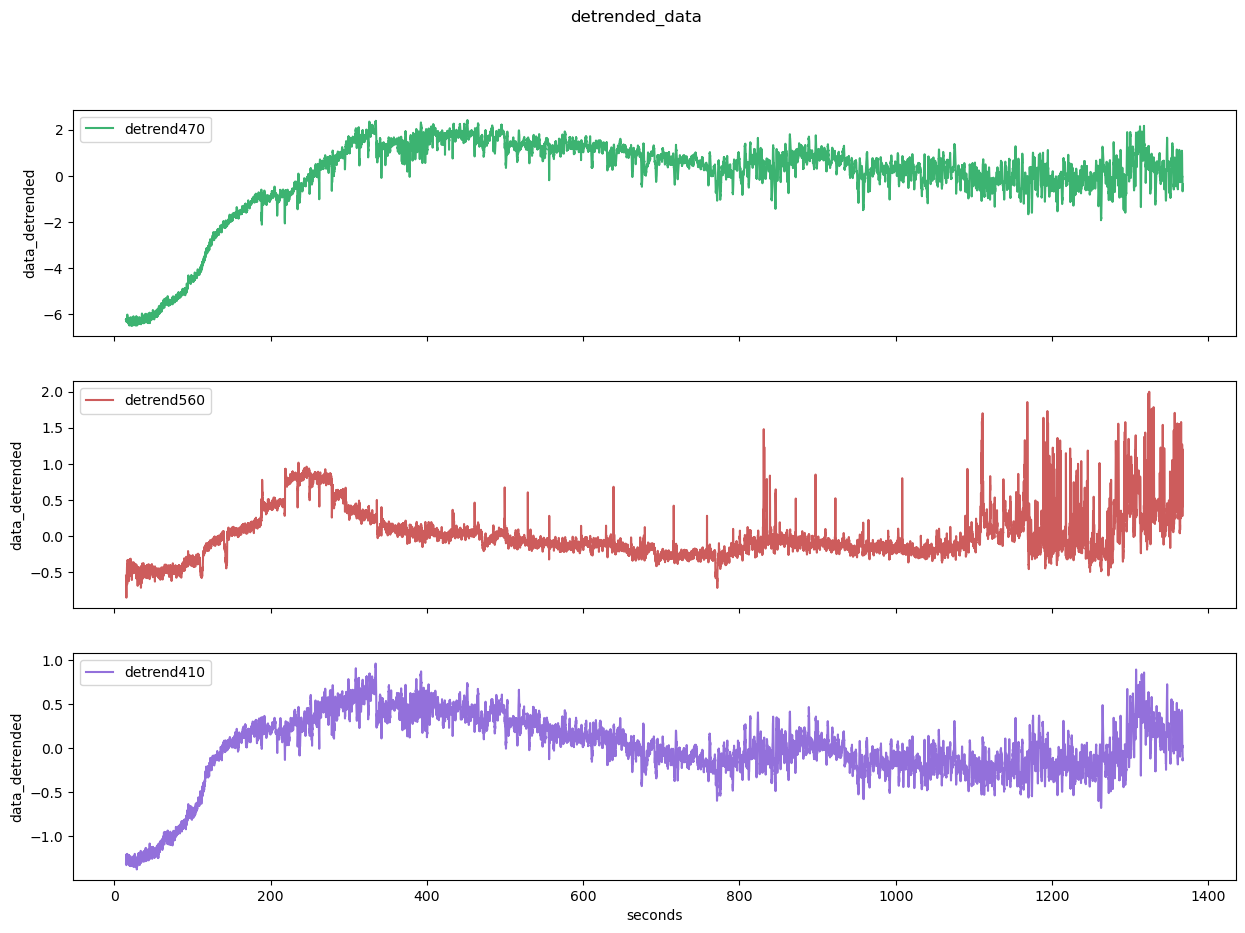

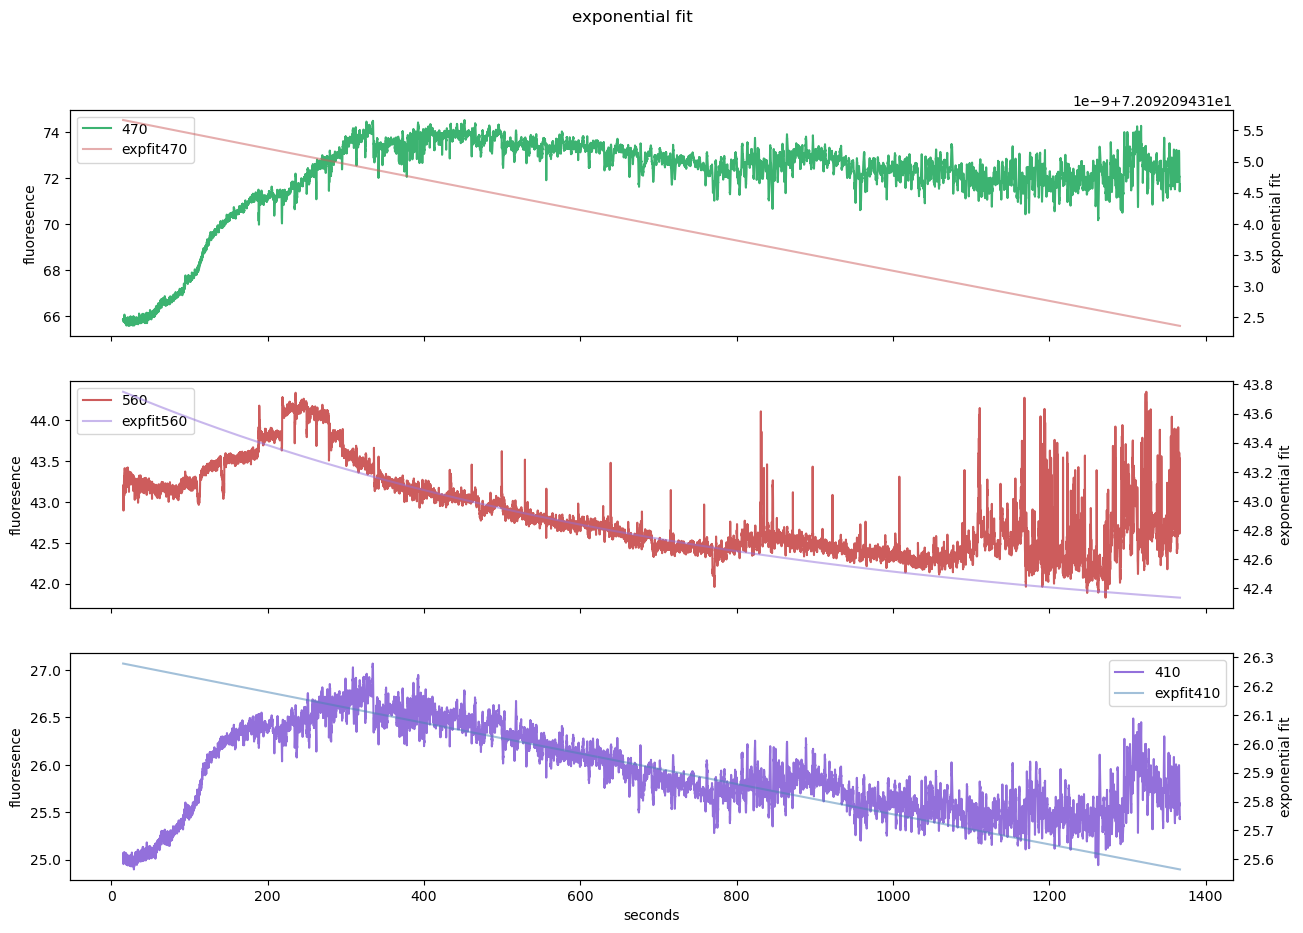

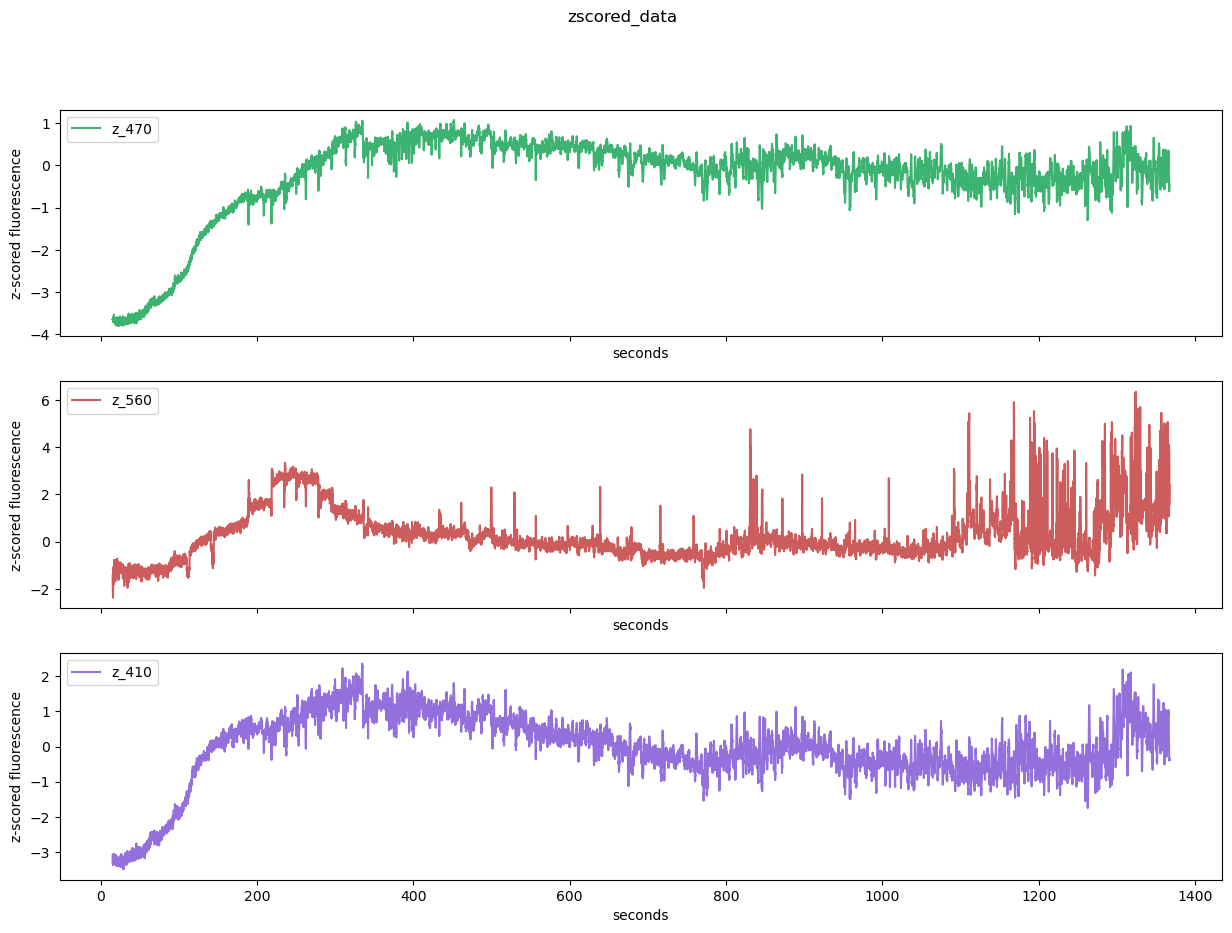

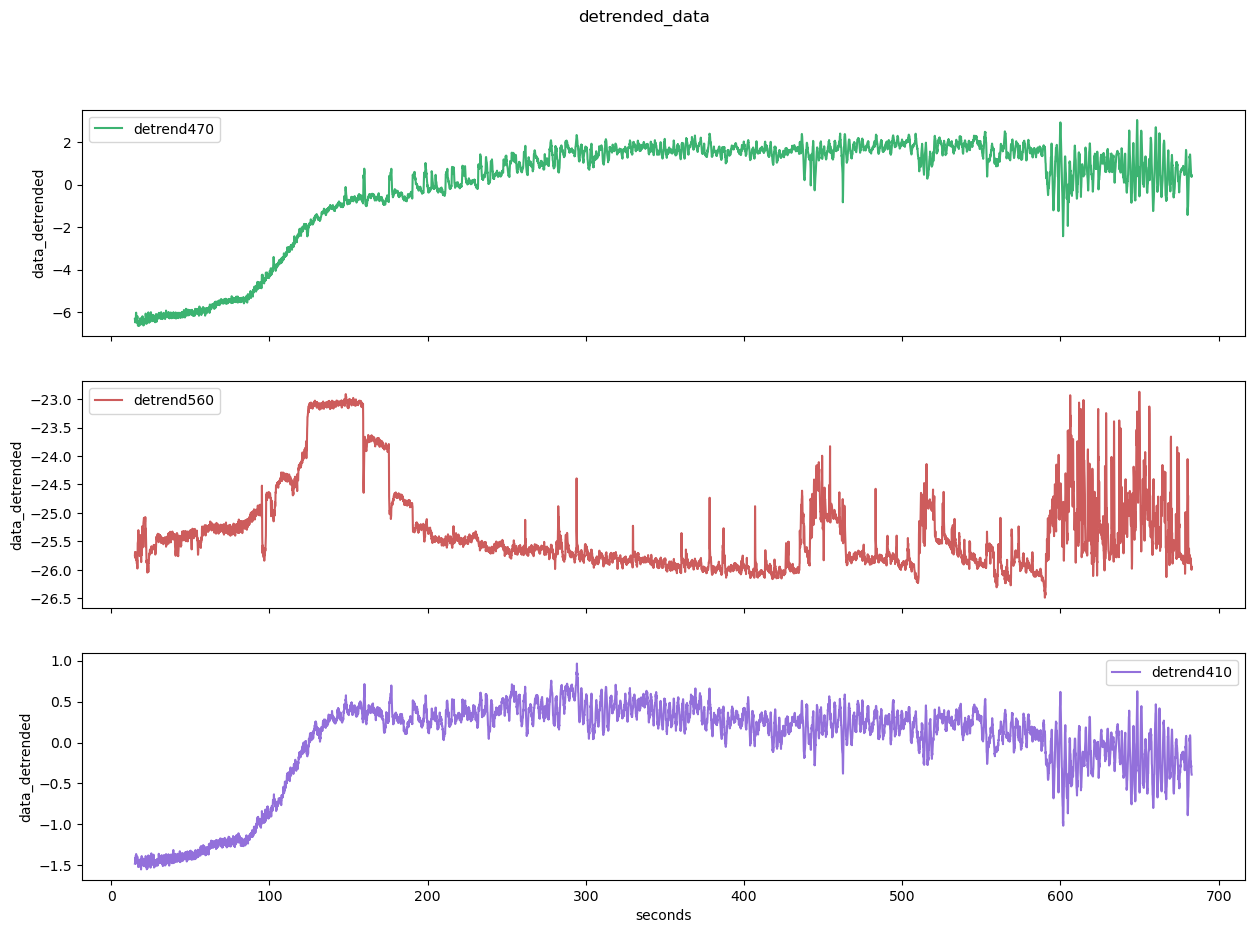

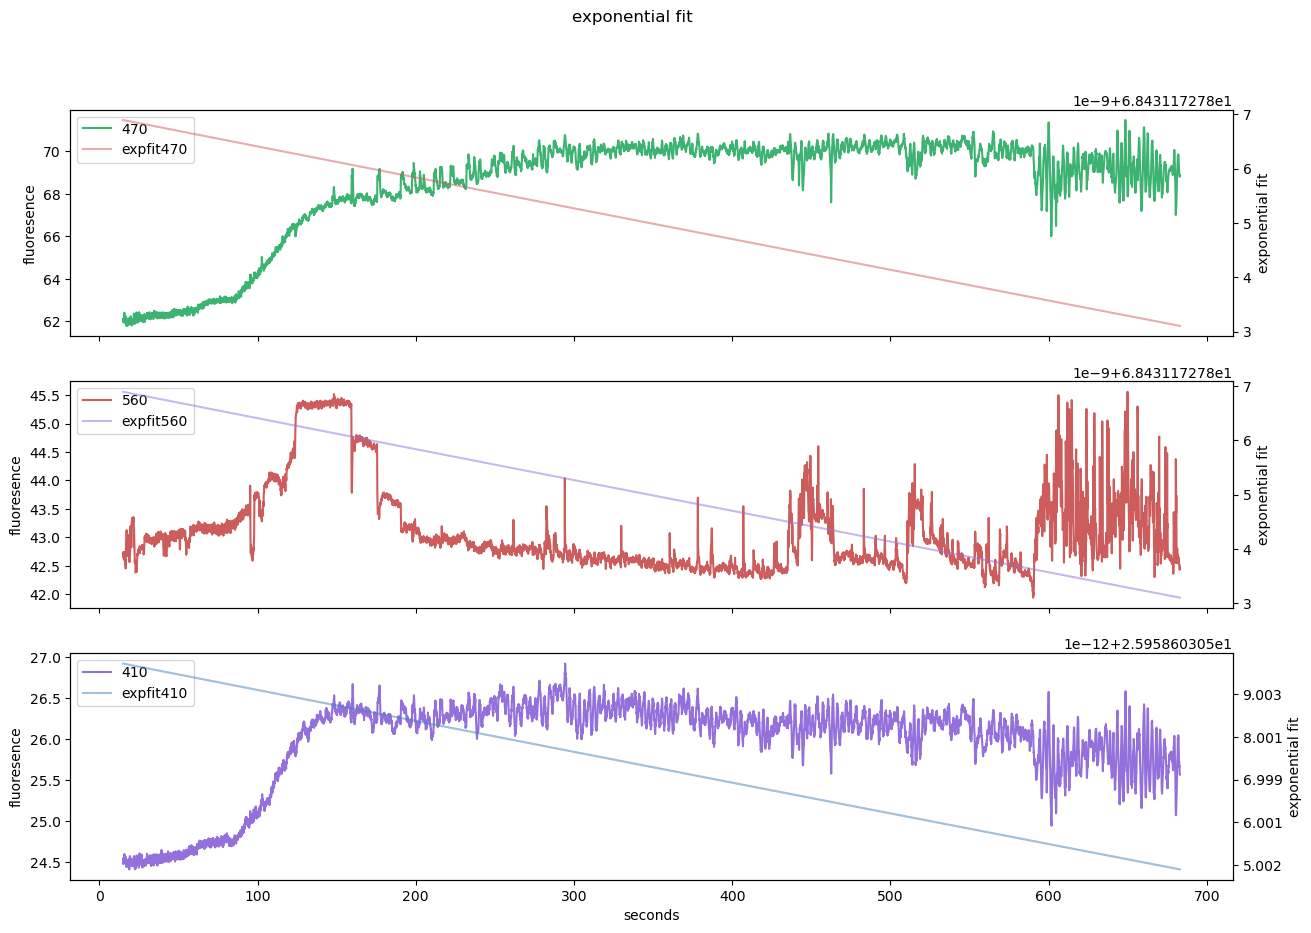

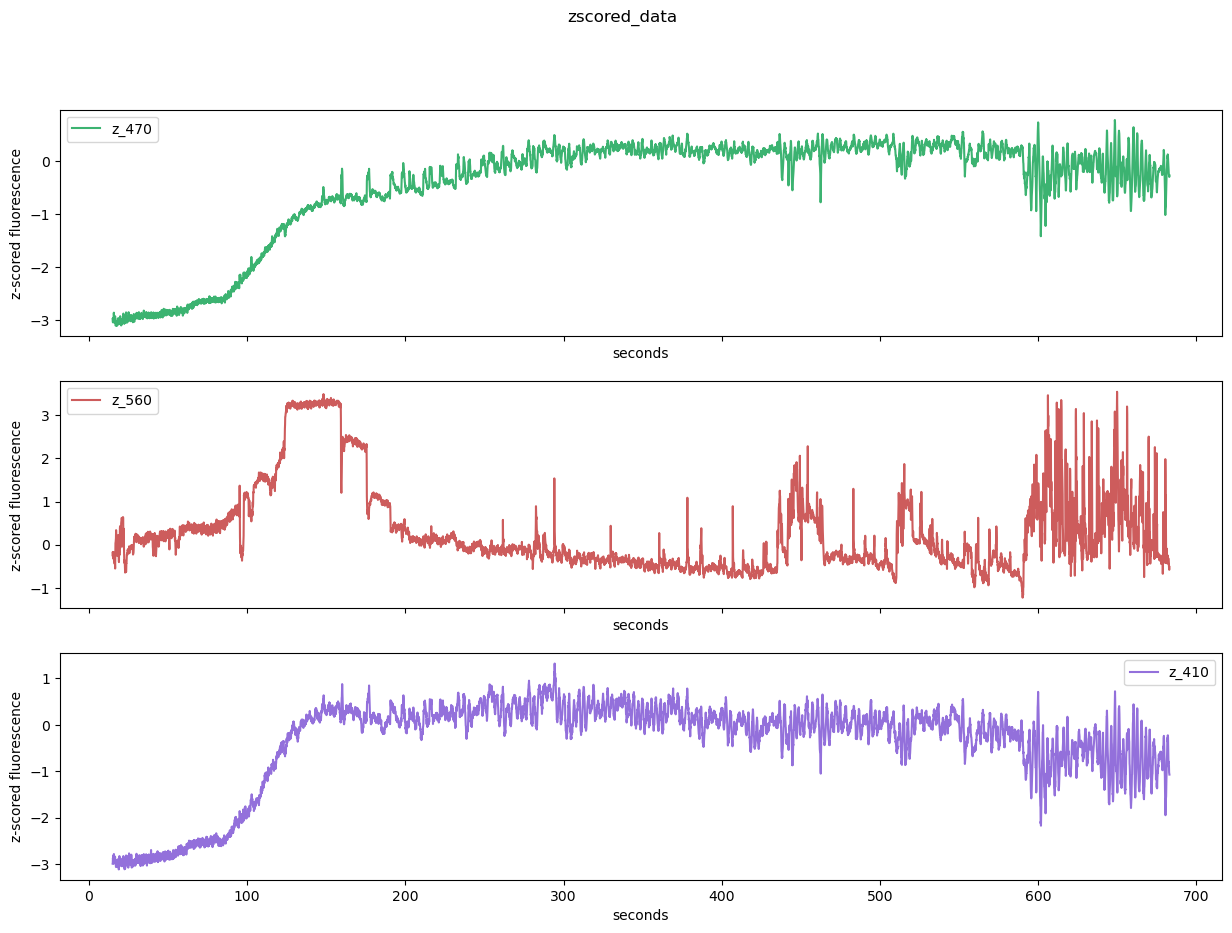

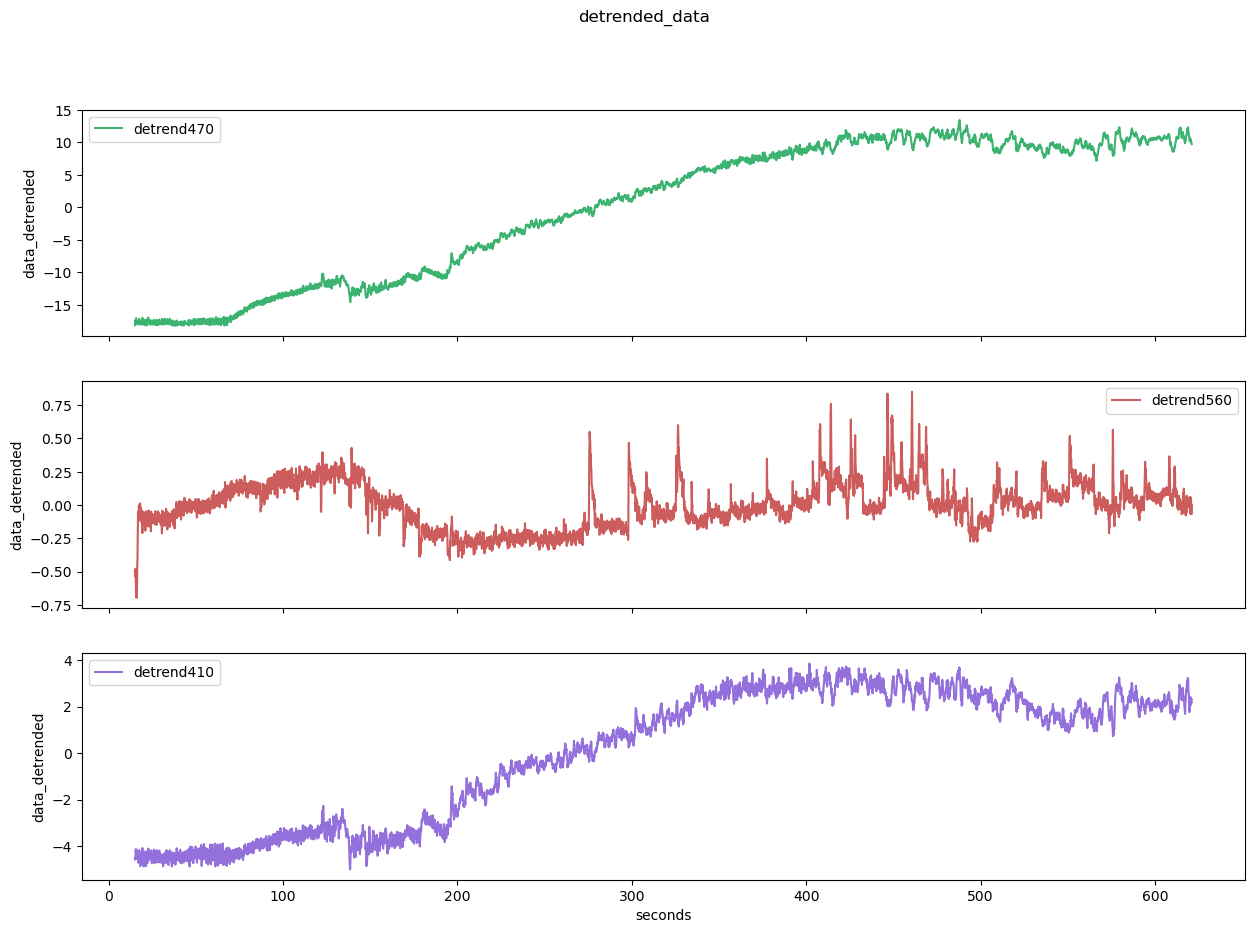

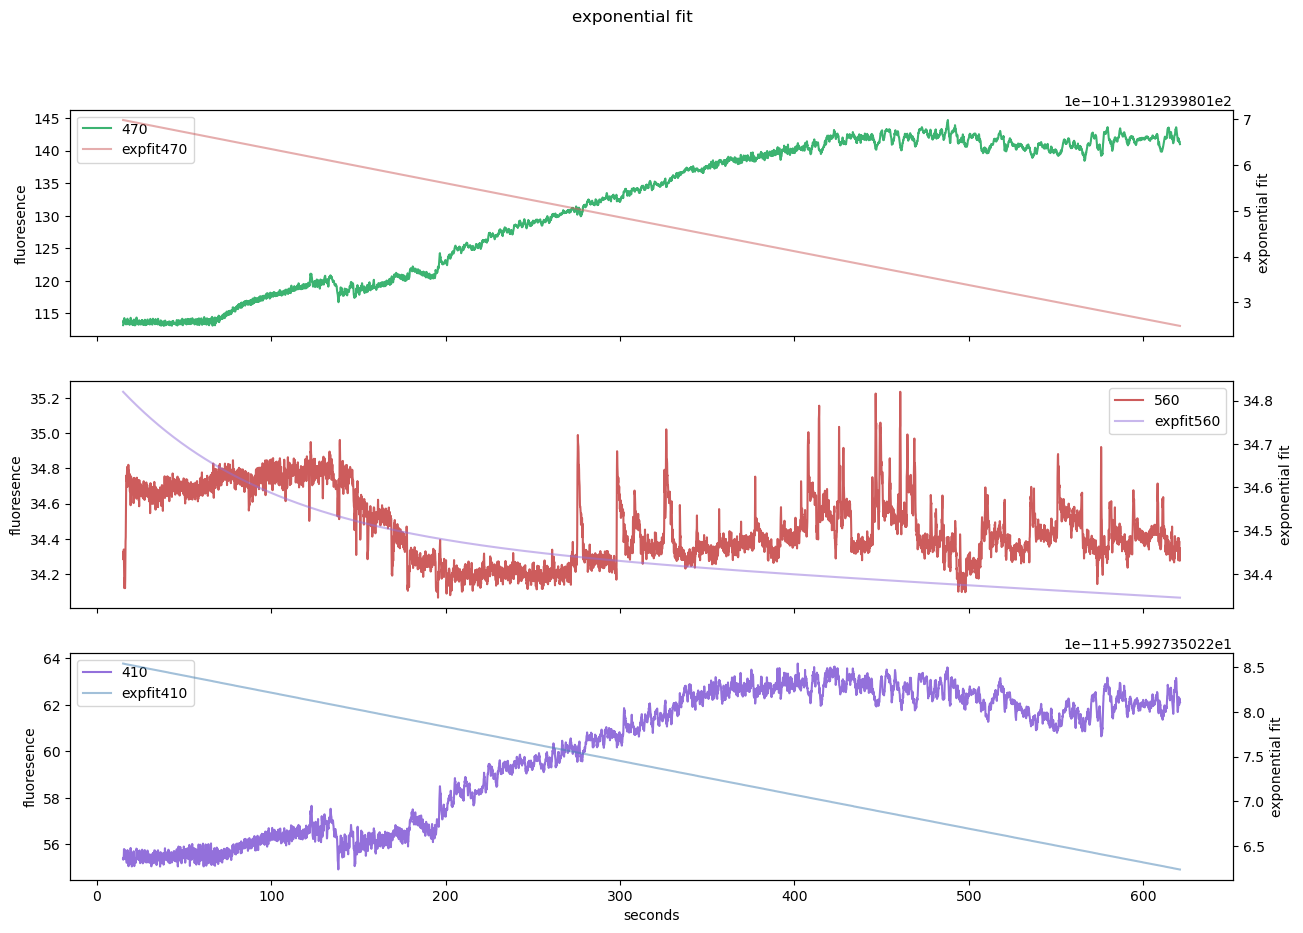

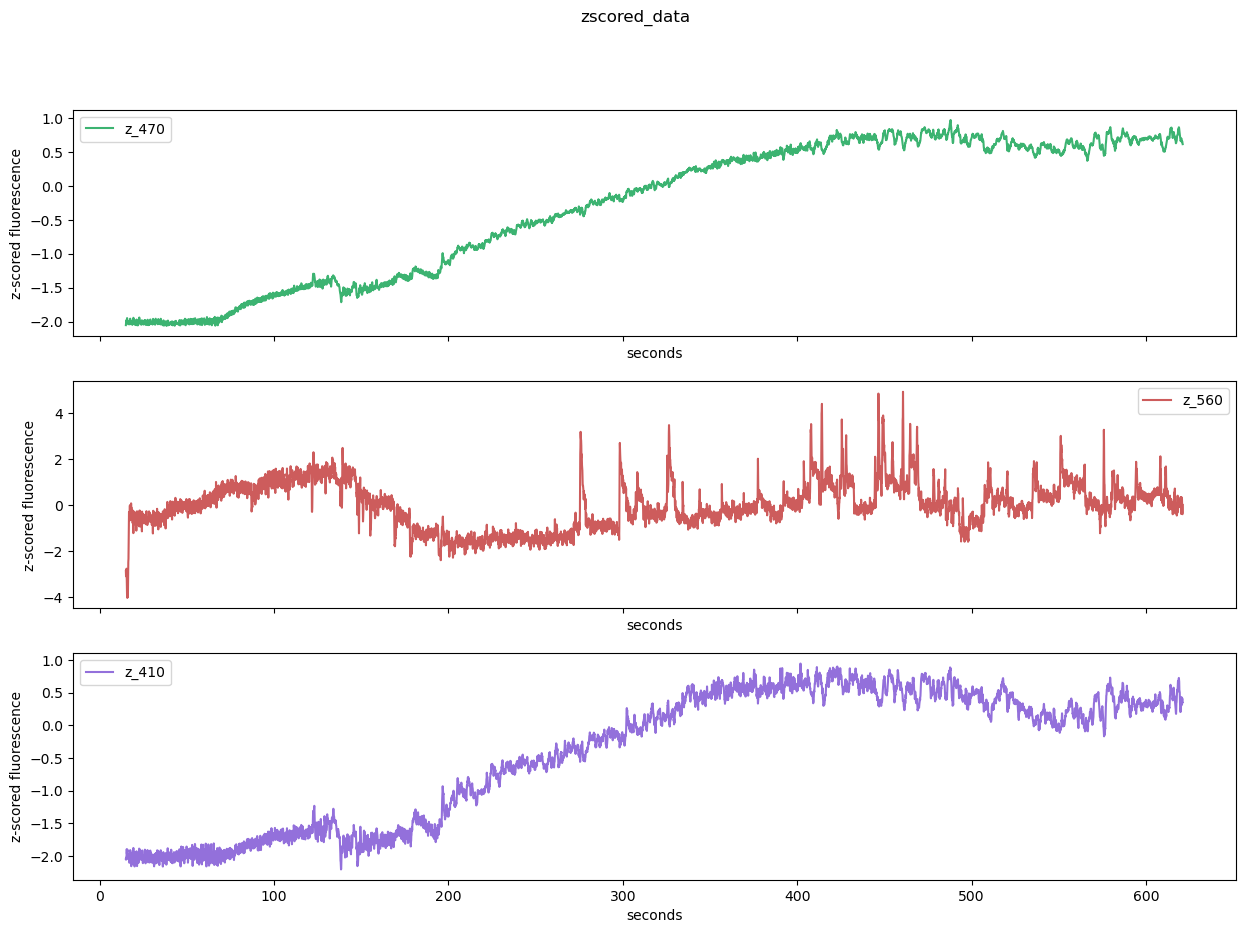

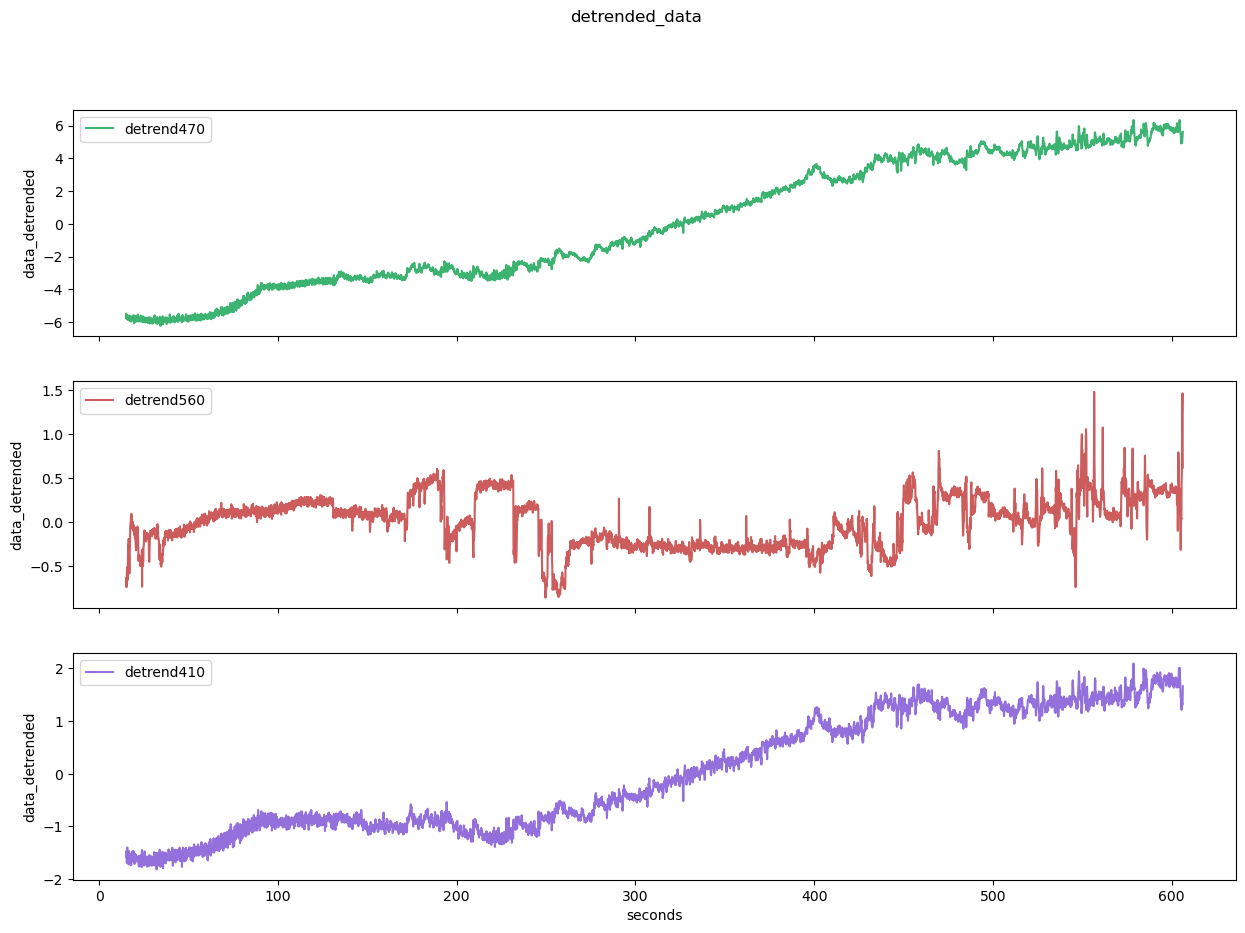

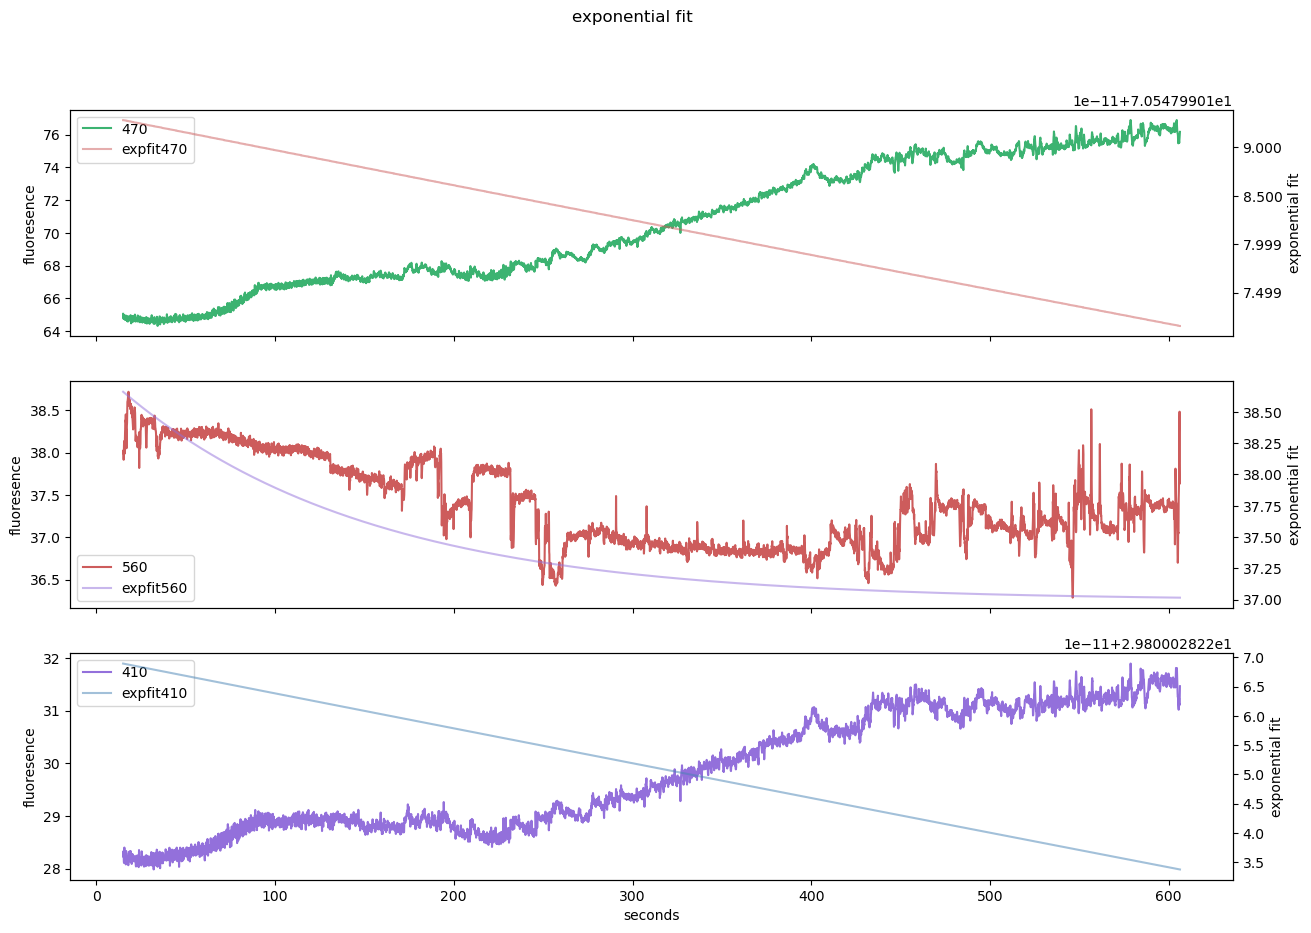

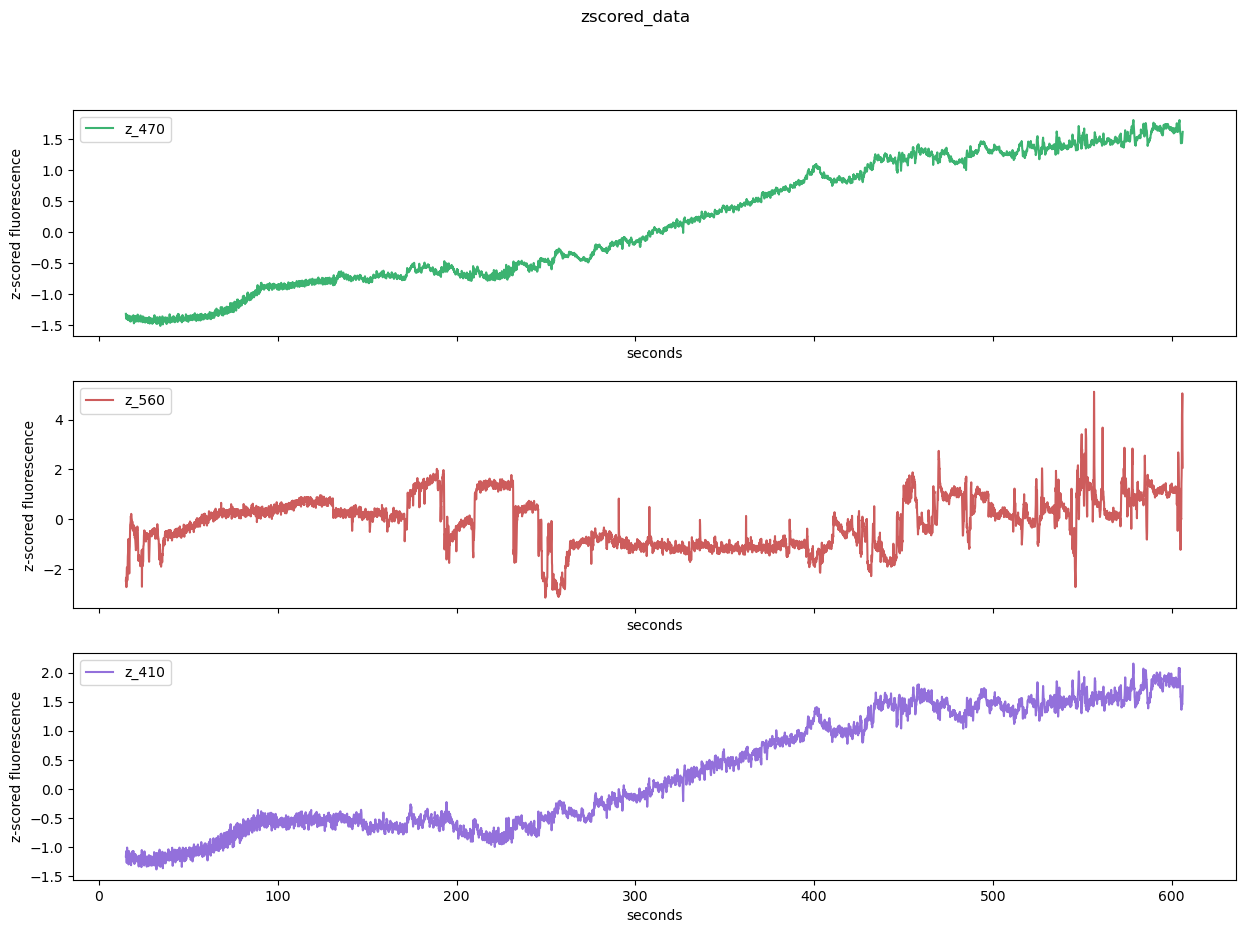

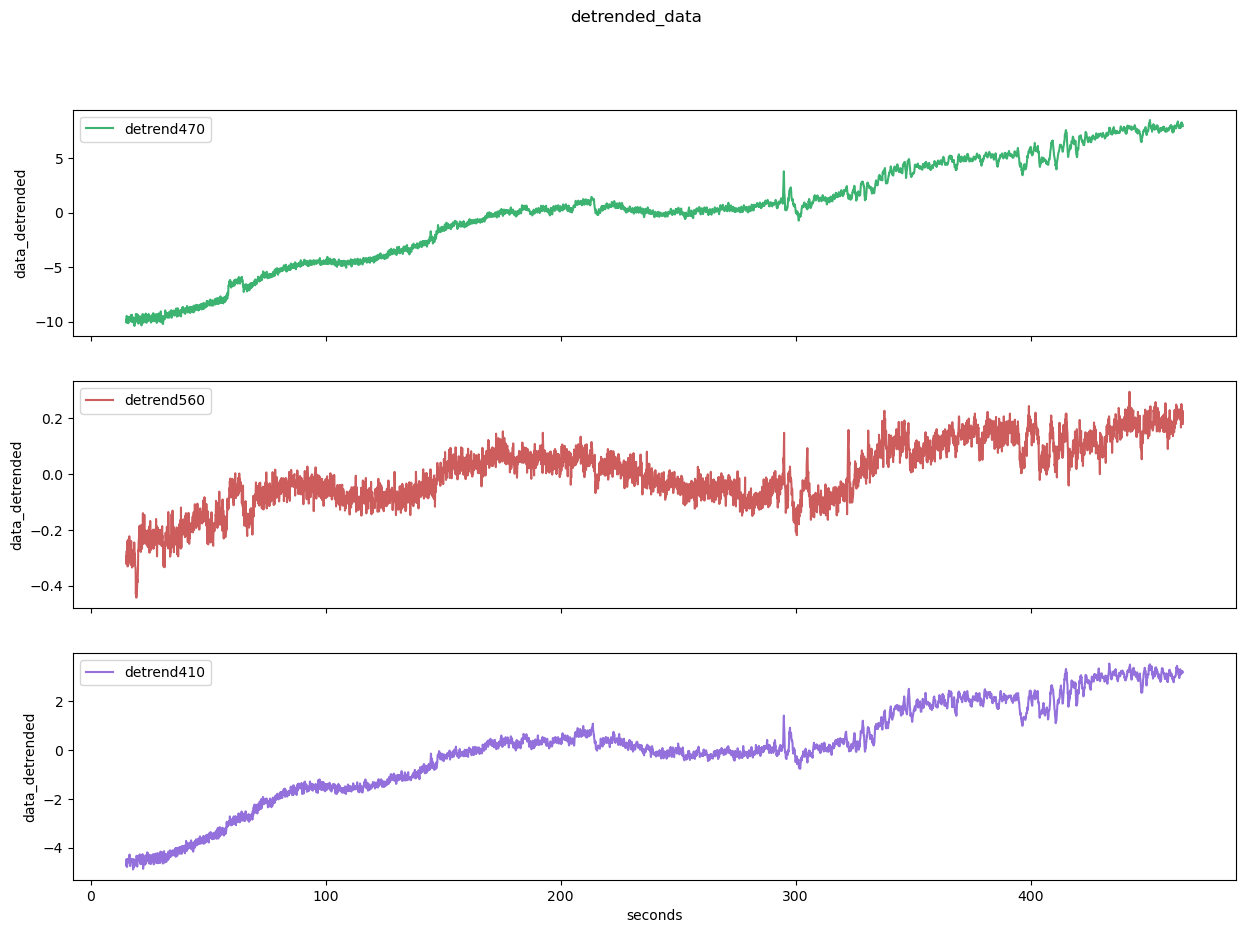

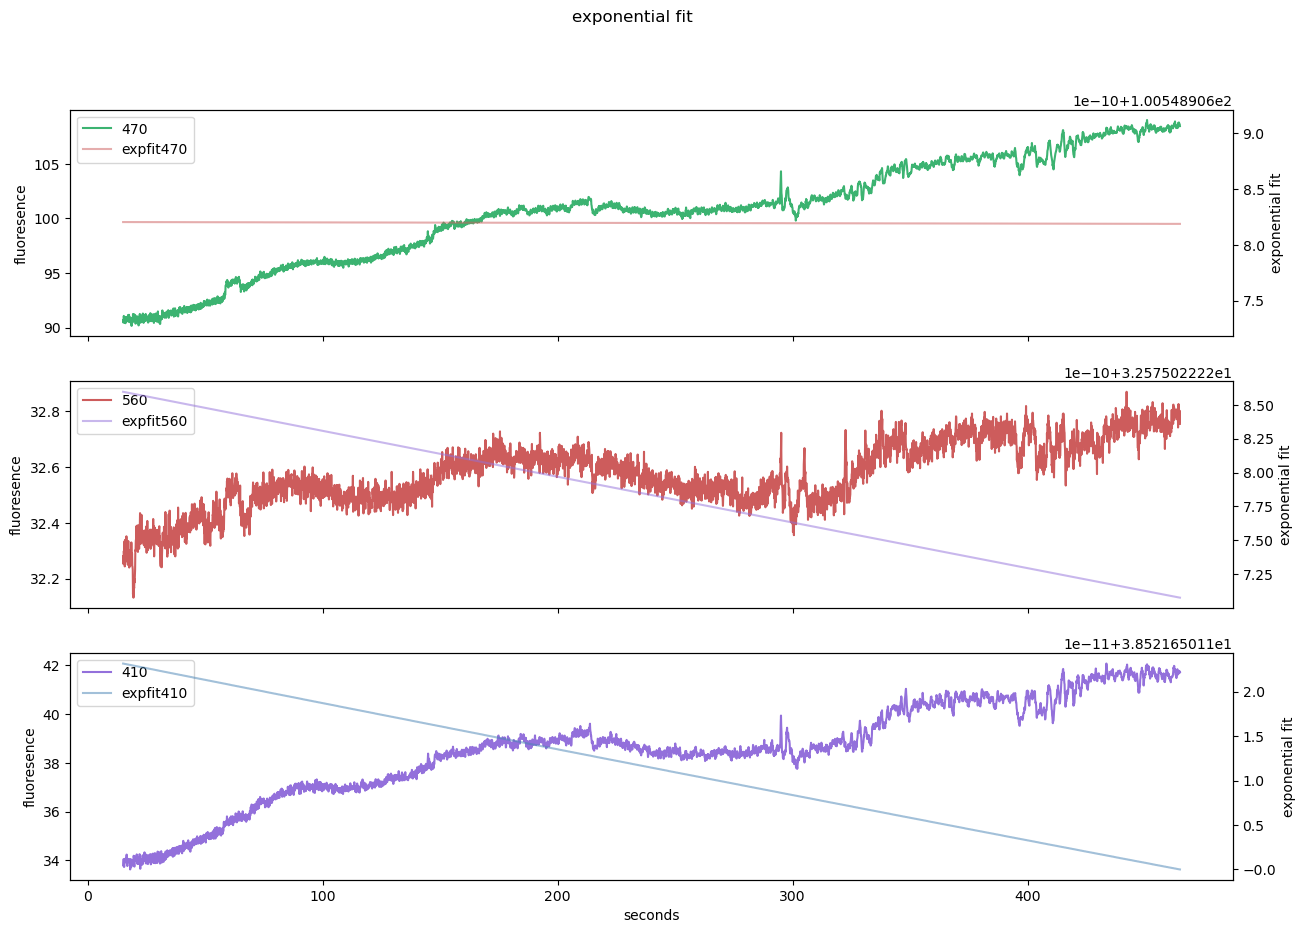

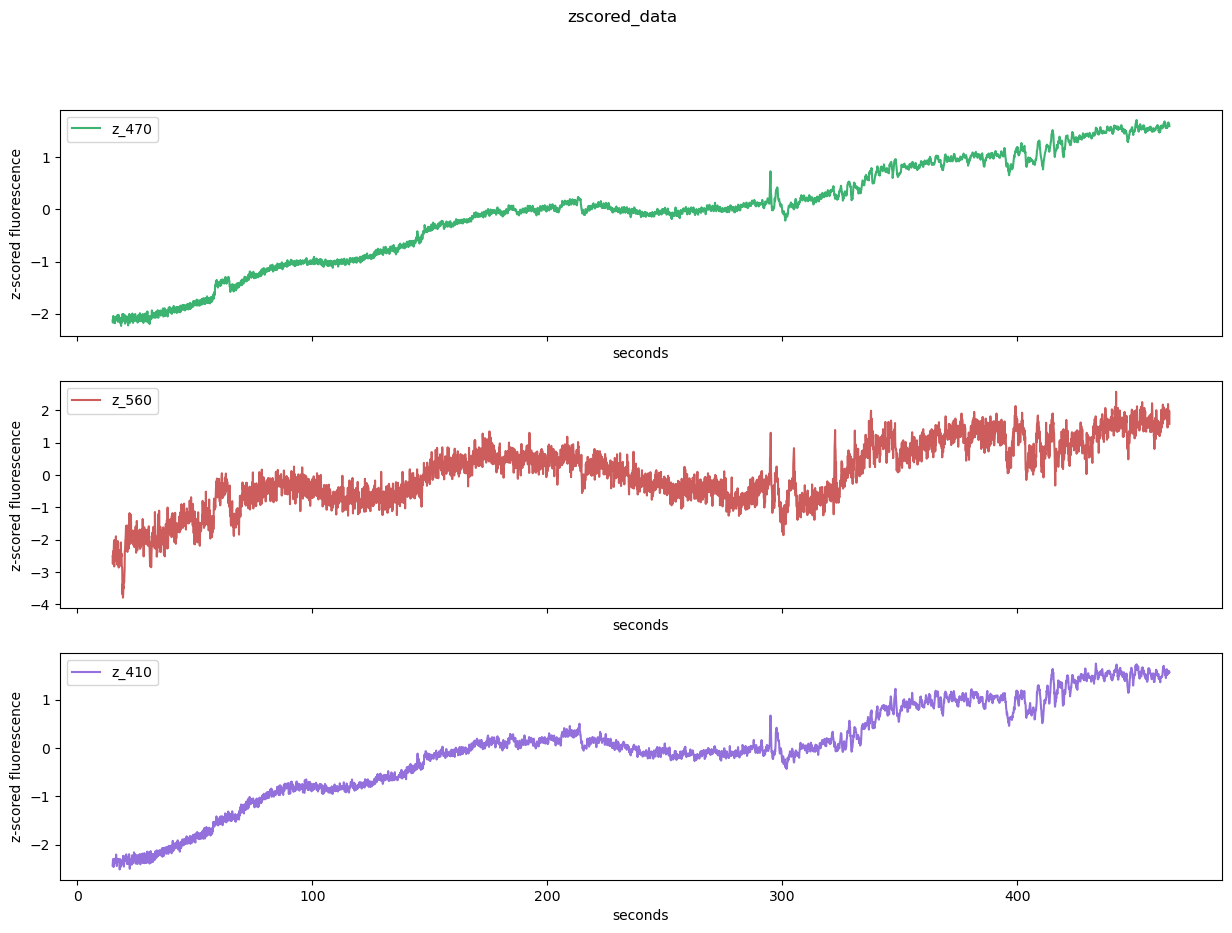

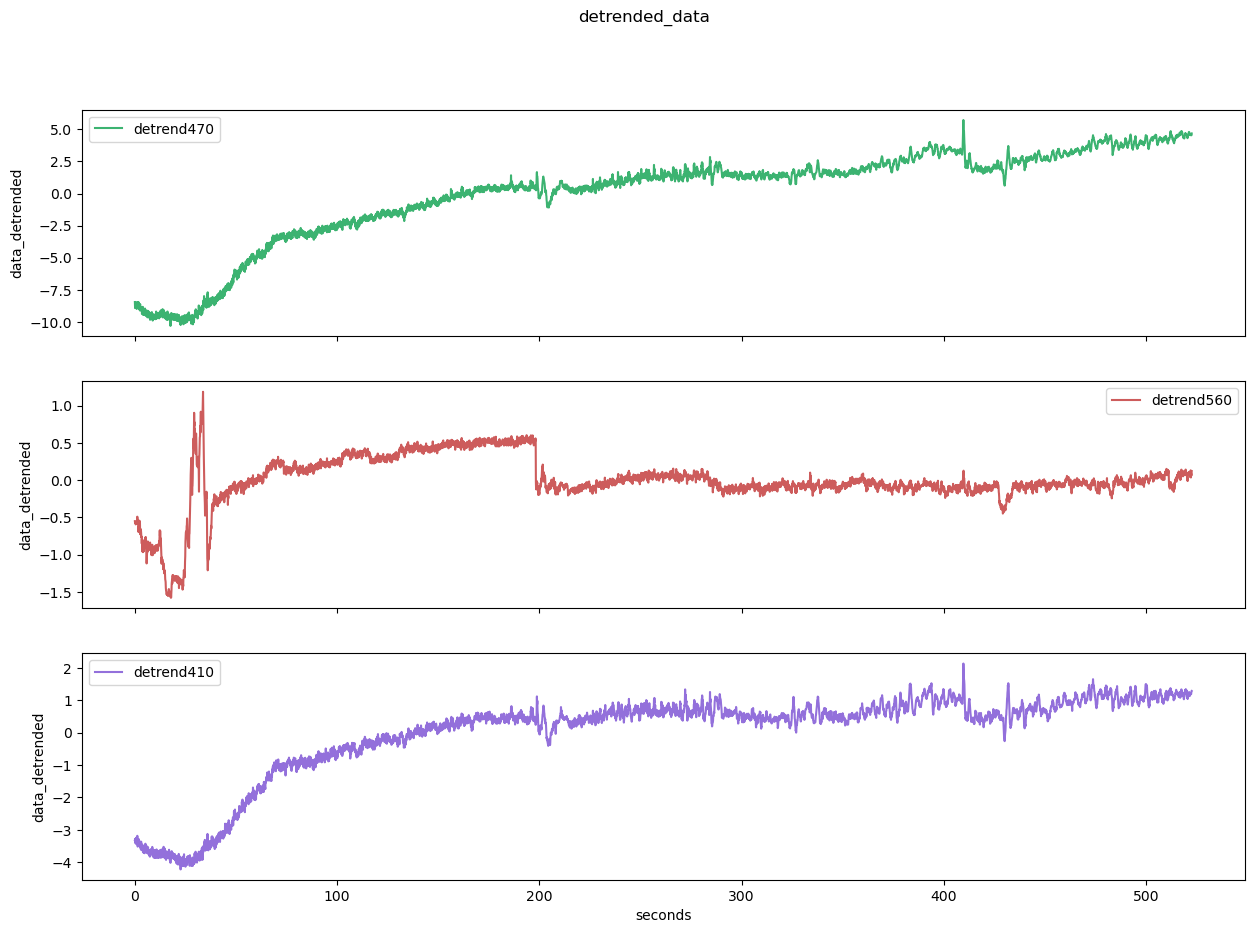

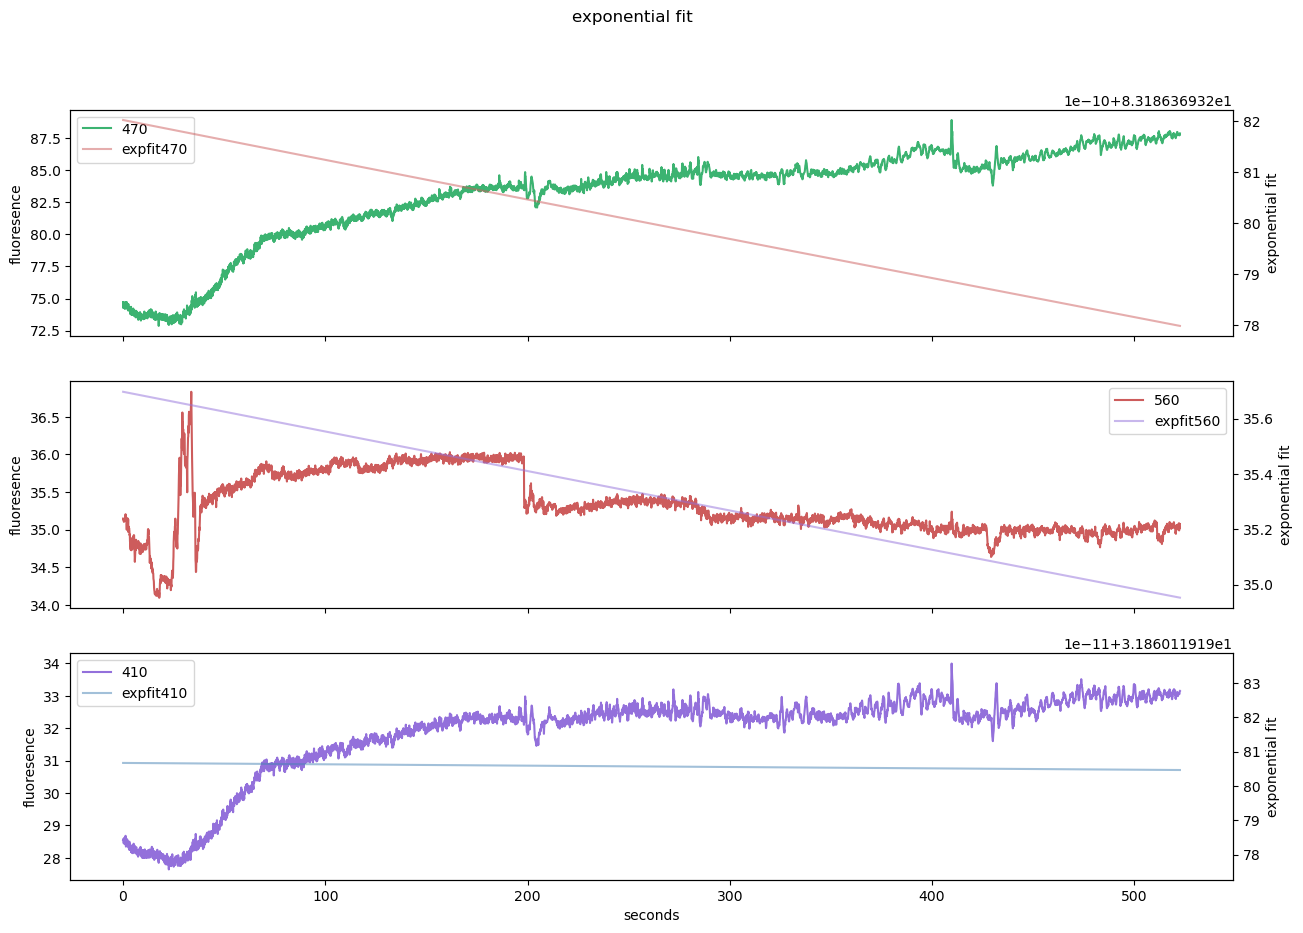

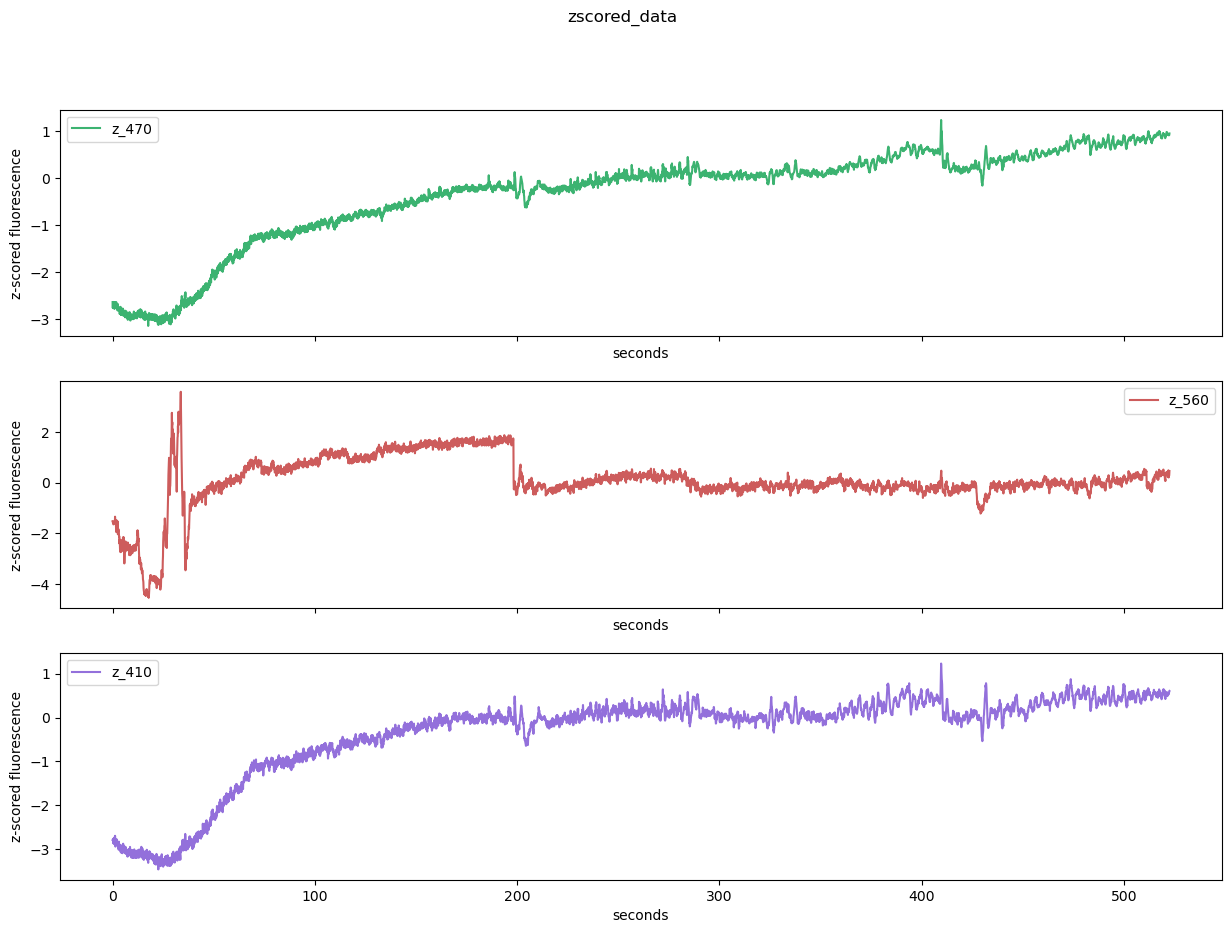

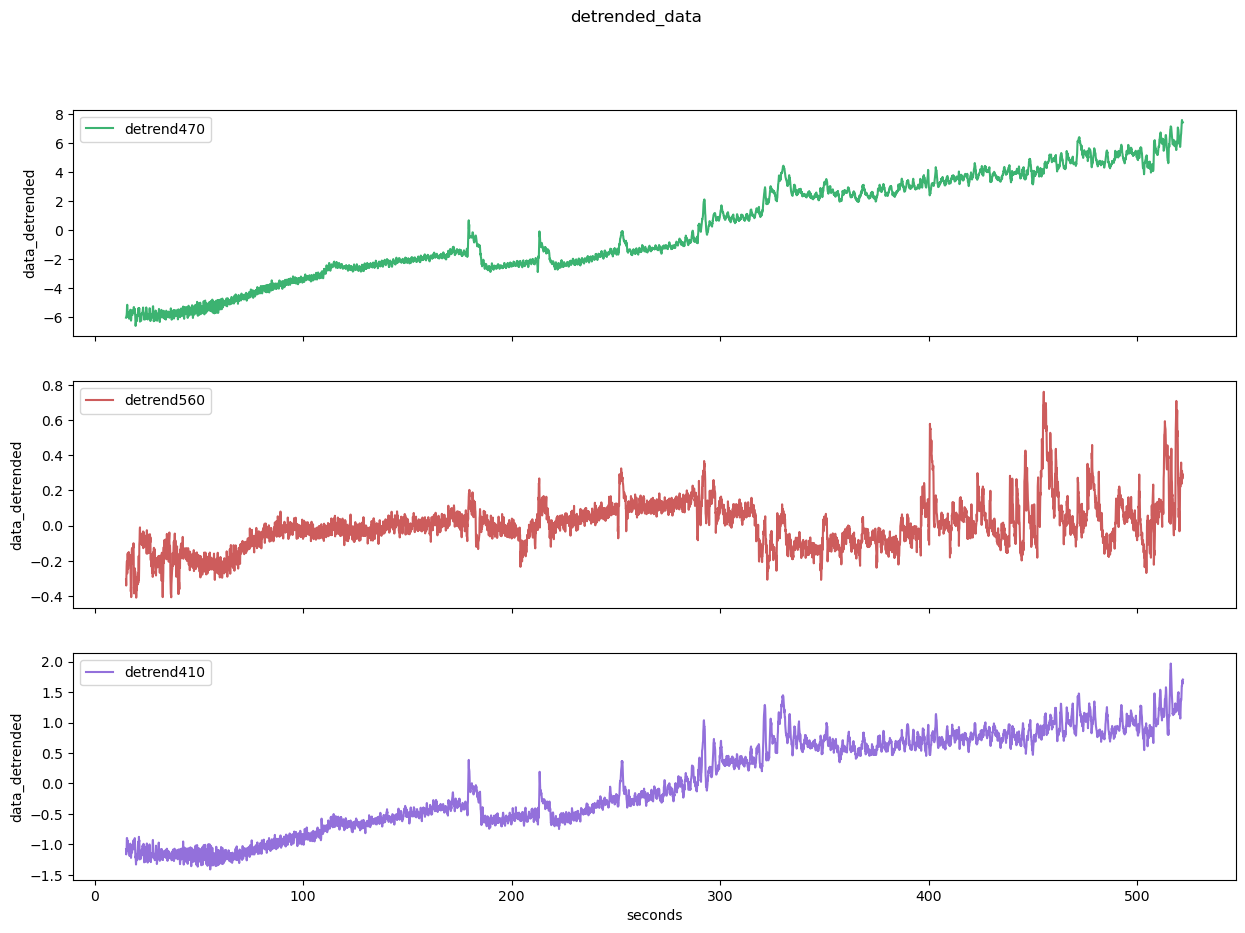

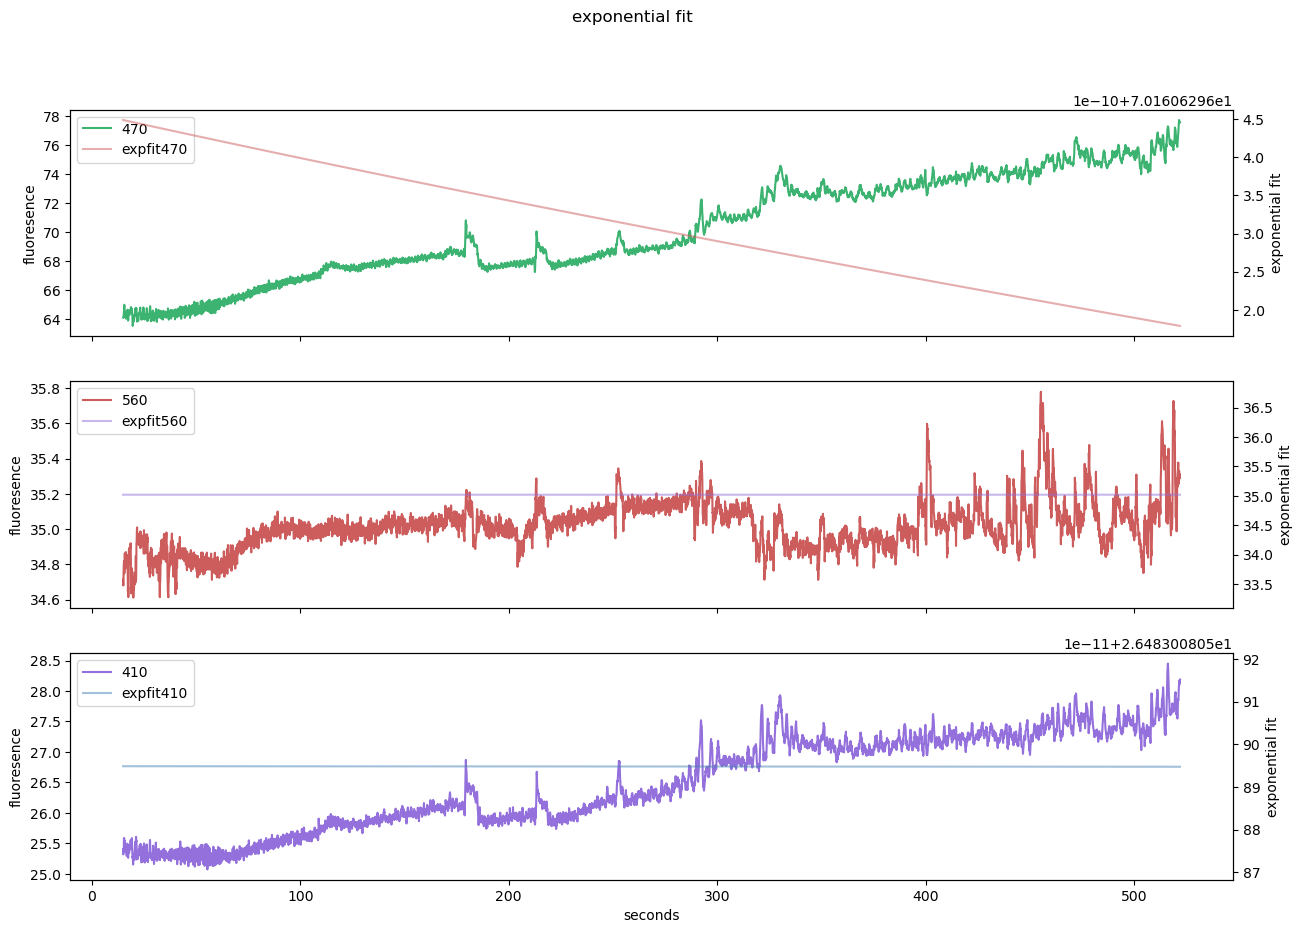

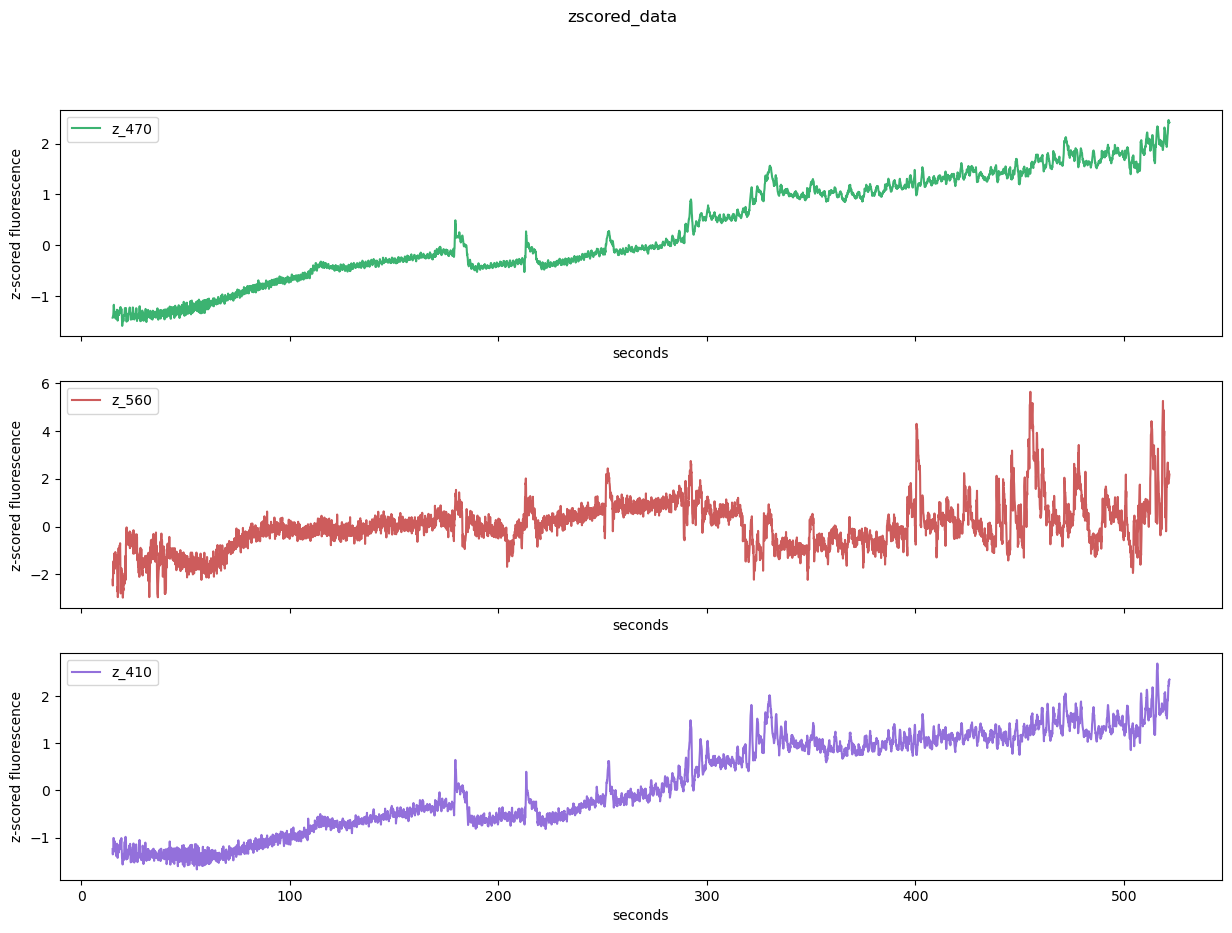

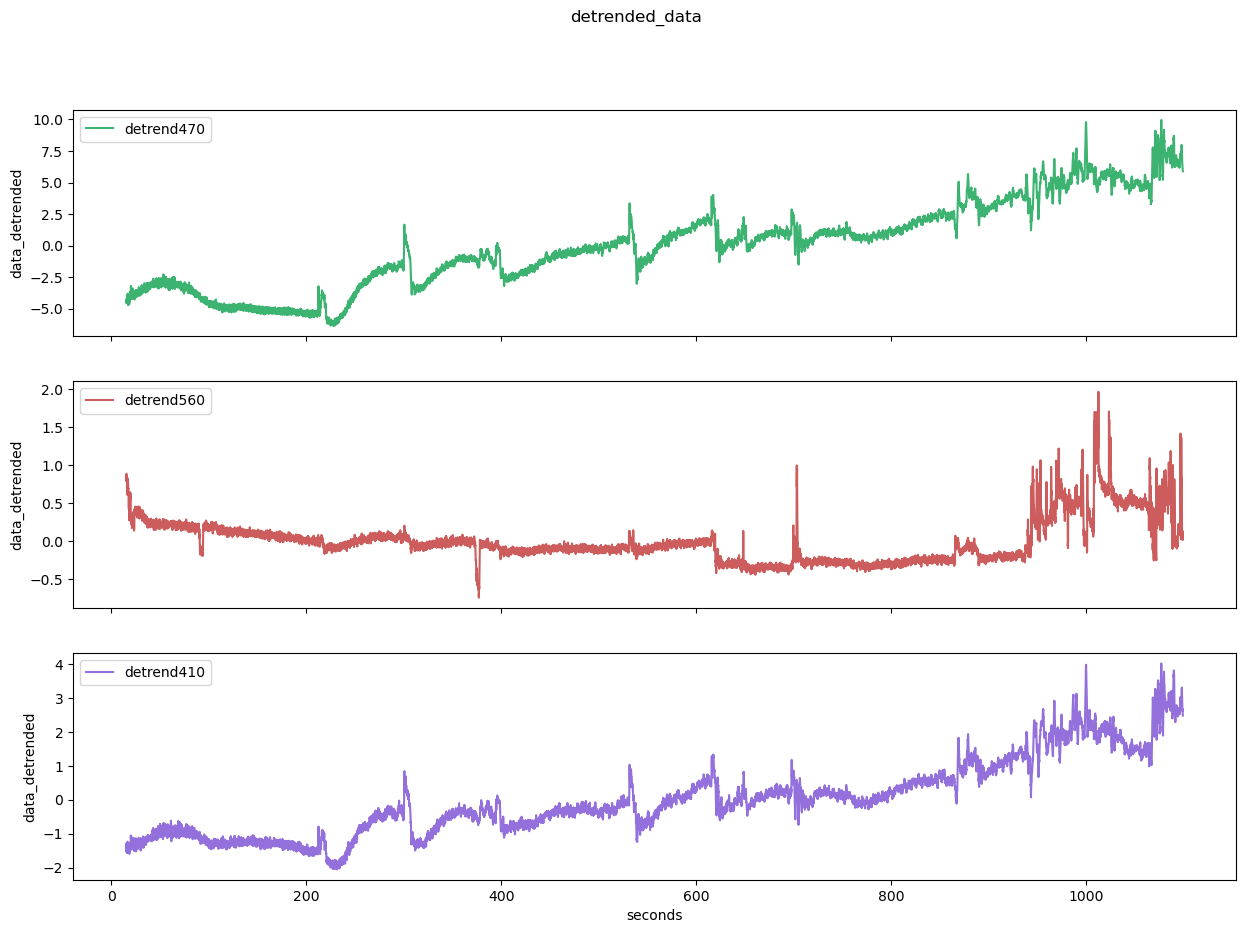

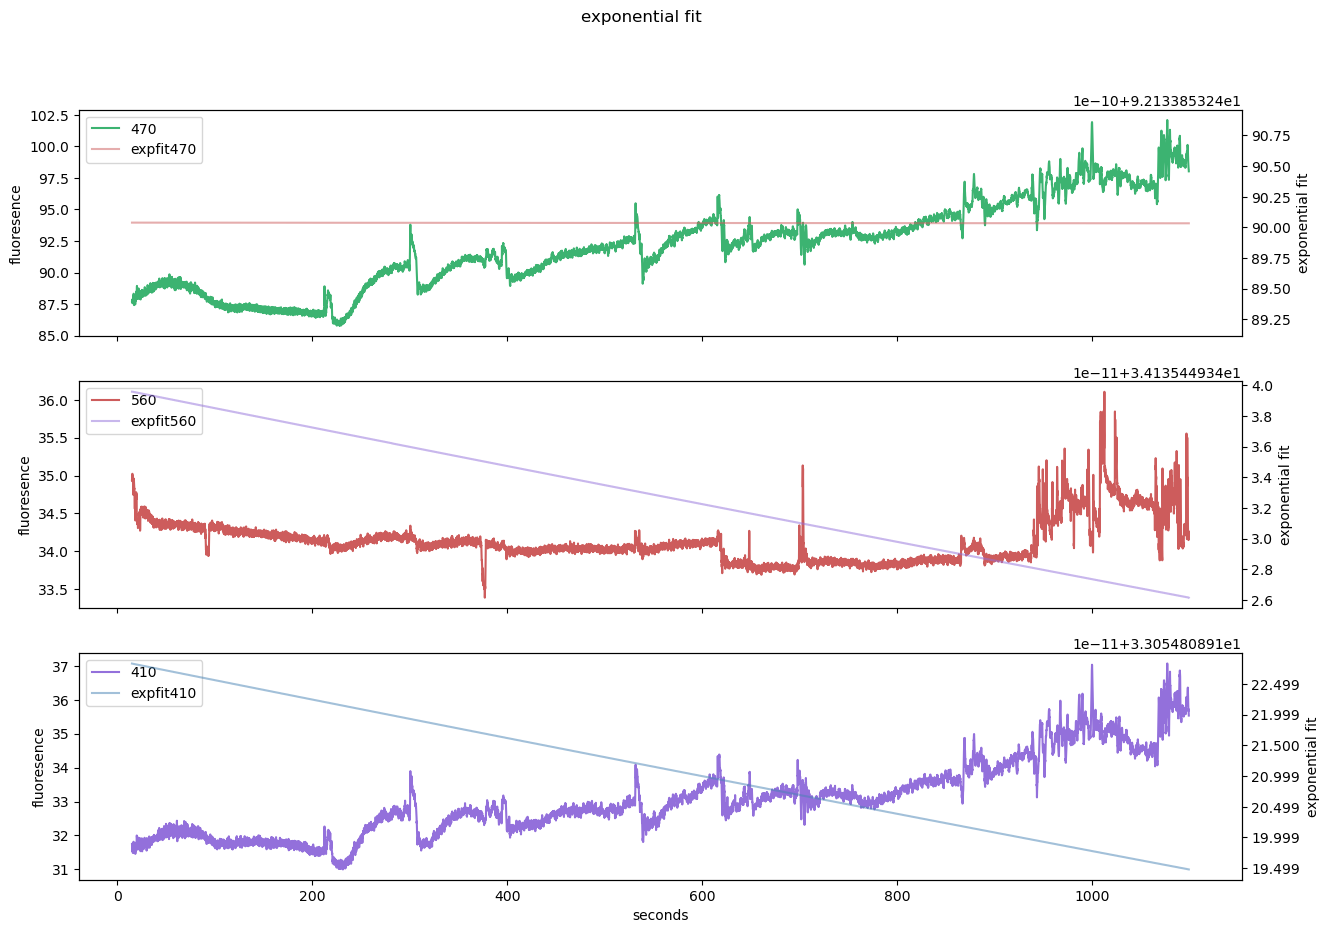

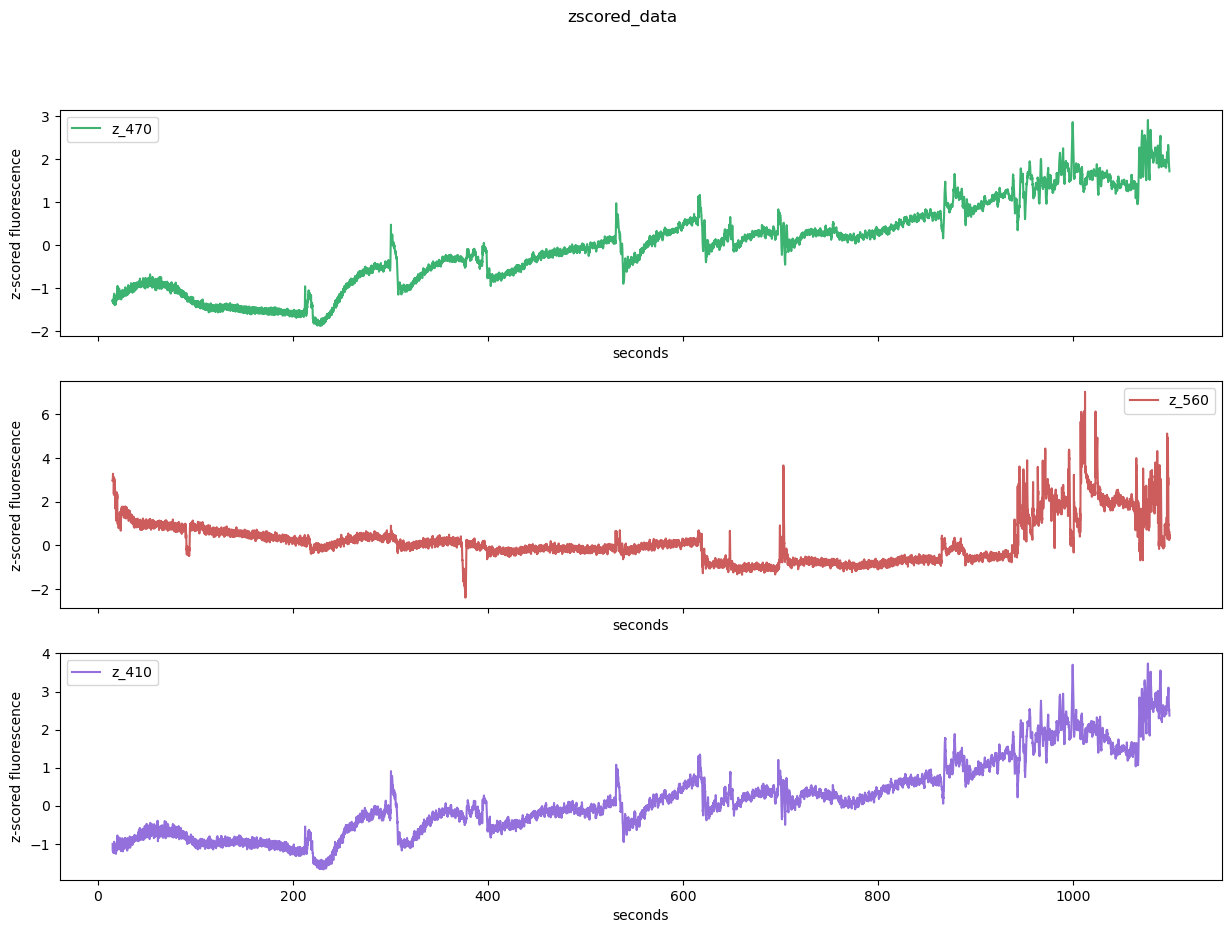

In [5]:
for path in paths: 
    sensors = ['g5-HT3']#['G8m'] #[1500]#['g5-HT3']#['G8m'] # provide sensor info, for now it can be: 'G8m', 'g5-HT3', or provide half decay time in ms
    processed = preprocess(path, sensors)
    processed.Info = processed.get_info()
    processed.rawdata, processed.data, processed.data_seconds, processed.signals, processed.save_path = processed.create_basic()
    processed.events = processed.extract_events()
    #processed.filtered = processed.low_pass_filt()
    processed.data_detrended, processed.exp_fits = processed.detrend()
    #processed.motion_corr = processed.movement_correct()
    processed.zscored = processed.z_score(motion = False)
    processed.deltaF_F = processed.deltaF_F(motion = False)
    processed.crucial_info = processed.add_crucial_info()

    processed.info_csv = processed.write_info_csv()

    processed.data_csv = processed.write_preprocessed_csv(Events = True, motion_correct = False)#Events = True) #optional: Events = True, motion_correct = True
